# Comparaison SWOT et marégraphes

Utilisation des données de la zcollection L2-LR-unsmoothed version PIB0 et PIC0 

Objectifs comparaison aux marégraphes :
- Choix des marégraphes (Lamena, Royan, Verdon-sur-Mer, Pauillac, fort-Medoc)
- Lecture fichier et application polygone
- Application critère de la grille
- Trouver les 10 points les plus proches
- Application correction l3 ou non de calibration
- Interpolation du geoïde IGN69
- Difference avec points au marégraphe

In [1]:
# Import des modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import seaborn as sns
#import julian
import time
import datetime
import matplotlib.ticker as ticker
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import scipy
from glob import glob
import os
from re import compile as re_compile
import re
import xarray as xr
import math

### 1- Récupération ssha dans SWOT au point du marégraphe

##### 1.1 Agglomération de tous les fichiers SWOT

In [2]:
station='verdon-sur-mer'

In [2]:
def extract_cycle(file):
    match = re.search(r'_Unsmoothed_(\d+)_', file)
    return int(match.group(1)) if match else -1

In [5]:
# Retrieve all swot files related to the station
#files = glob('/mnt/summit22/data/altimetry/SWOT/science/L2-LR-unsmoothed-Zcollection/gironde/data/*_419_*.nc')
#files = glob('/mnt/summit22/data/altimetry/SWOT/science/L2-LR-unsmoothed-Zcollection/tracks/*_348_*.nc')+ glob('/mnt/summit22/data/altimetry/SWOT/science/L2-LR-unsmoothed-Zcollection/tracks/*_419_*.nc')
files = glob('/mnt/summit22/data/altimetry/SWOT/science/L2-LR-unsmoothed-Zcollection/tracks/*.nc')
swot_files = [f for f in files if os.path.isfile(f)]
swot_files=sorted(swot_files,key=extract_cycle)
area=[357.5,0.1,44.5, 46.3]
area=[357.5,0.1,44.5, 46.3]#348
#area=[358,0.8,44.5,46.5]#113
#area=[357.0,359.6,44.5,46.5] #419
swot_files

['/mnt/summit22/data/altimetry/SWOT/science/L2-LR-unsmoothed-Zcollection/tracks/SWOT_L2_LR_SSH_Unsmoothed_001_419_20230805T043308_20230805T044024_PGC0_01.nc',
 '/mnt/summit22/data/altimetry/SWOT/science/L2-LR-unsmoothed-Zcollection/tracks/SWOT_L2_LR_SSH_Unsmoothed_001_348_20230802T151538_20230802T152253_PGC0_01.nc',
 '/mnt/summit22/data/altimetry/SWOT/science/L2-LR-unsmoothed-Zcollection/tracks/SWOT_L2_LR_SSH_Unsmoothed_002_348_20230823T120043_20230823T120758_PGC0_01.nc',
 '/mnt/summit22/data/altimetry/SWOT/science/L2-LR-unsmoothed-Zcollection/tracks/SWOT_L2_LR_SSH_Unsmoothed_002_419_20230826T011813_20230826T012528_PGC0_02.nc',
 '/mnt/summit22/data/altimetry/SWOT/science/L2-LR-unsmoothed-Zcollection/tracks/SWOT_L2_LR_SSH_Unsmoothed_002_113_20230815T025525_20230815T030241_PGC0_01.nc',
 '/mnt/summit22/data/altimetry/SWOT/science/L2-LR-unsmoothed-Zcollection/tracks/SWOT_L2_LR_SSH_Unsmoothed_003_113_20230904T234031_20230904T234746_PGC0_01.nc',
 '/mnt/summit22/data/altimetry/SWOT/science/L2

##### 1.2 Compléter chaque fichier SWOT avec geoïde et calcul ssha

In [74]:
# Découpage de la zone d'étude
def polygone(ds,area):
    # Conditions sur la latitude
    lat=ds.latitude.values
    indices=np.array(np.where((lat > area[2]) & (lat<area[3])))[0]
    max_lat=indices.max()
    min_lat=indices.min()

    # Conditions sur la longitude
    lon=ds.longitude.values
    indices=np.array(np.where((lon > area[0]) & (lon<area[1])))[0]
    max_lon=indices.max()
    min_lon=indices.min()

    # Conditions sur longitude et latitude
    lines_max=min(max_lat,max_lon)
    lines_min=min(min_lat,min_lon)
    lines_min,lines_max

    ds_new=ds.sel(num_lines=slice(lines_min,lines_max))
    return ds_new

In [7]:
# Interpolation du geoïde IGN69 sur grille SWOT

def interpolation_geoide_swot(ds,ds_geoid):
    lat_geo=ds_geoide.lat.values.flatten()
    lon_geo=ds_geoide.lon.values.flatten()
    mask_neg=np.where(lon_geo<0)
    lon_geo[mask_neg]=360+lon_geo[mask_neg]
    mask_zero=np.where(lon_geo==0)
    lon_geo[mask_zero]=0
    grid_geo=np.transpose(np.array([lon_geo,lat_geo]))
    lat_swot=ds.latitude.values.flatten()
    lon_swot=ds.longitude.values.flatten()
    grid_swot=np.transpose(np.array([lon_swot,lat_swot]))

    ign69_val=ds_geoide.ign69.values.flatten()
    interp_data=scipy.interpolate.griddata((lon_geo,lat_geo),ign69_val,(ds.longitude.values,ds.latitude.values),method='linear')
    lat_swot_bis=ds.latitude.values
    taille=np.shape(lat_swot_bis)
    ign69_interp=np.reshape(interp_data,(taille[0],taille[1]))
    da=xr.DataArray(interp_data,dims={'num_lines':taille[0],'num_pixels':taille[1]})
    ds["ign69"]=da
    #plt.pcolor(interp_data)
    return ds
    

In [75]:
# Calcul des ssha corrigées ou non de la correction cross track 
# Certains fichier n'ont pas le même champ de calibration

def calcul_ssha_calinterp(ds):
    #ds['ssha_cor_l3_zcoll']=ds.ssh_karin_2+ds.calibration_zcoll_l3-ds.ign69-ds.load_tide_fes_interp_l2expert-ds.solid_earth_tide_interp_l2expert
    ds['ssha_no_cor']=ds.ssh_karin_2-ds.ign69-ds.load_tide_fes_interp_l2expert-ds.solid_earth_tide_interp_l2expert
    ds['ssha_cor_l3_interp']=ds.ssh_karin_2+ds.calibration_interp_l3_2km-ds.ign69-ds.load_tide_fes_interp_l2expert-ds.solid_earth_tide_interp_l2expert
    return ds

def calcul_ssha_calzcoll(ds):
    #ds['ssha_cor_l3_zcoll']=ds.ssh_karin_2+ds.calibration_zcoll_l3-ds.ign69-ds.load_tide_fes_interp_l2expert-ds.solid_earth_tide_interp_l2expert
    ds['ssha_no_cor']=ds.ssh_karin_2-ds.ign69-ds.load_tide_fes_interp_l2expert-ds.solid_earth_tide_interp_l2expert
    ds['ssha_cor_l3_interp']=ds.ssh_karin_2+ds.calibration_zcoll_l3-ds.ign69-ds.load_tide_fes_interp_l2expert-ds.solid_earth_tide_interp_l2expert
    return ds

def calcul_ssha_calmci(ds):
    #ds['ssha_cor_l3_zcoll']=ds.ssh_karin_2+ds.calibration_zcoll_l3-ds.ign69-ds.load_tide_fes_interp_l2expert-ds.solid_earth_tide_interp_l2expert
    ds['ssha_no_cor']=ds.ssh_karin_2-ds.ign69-ds.load_tide_fes_interp_l2expert-ds.solid_earth_tide_interp_l2expert
    ds['ssha_cor_l3_interp']=ds.ssh_karin_2+ds.calibration_curvature-ds.ign69-ds.load_tide_fes_interp_l2expert-ds.solid_earth_tide_interp_l2expert
    return ds

def calcul_ssha_calinterp_nossb(ds):
    #ds['ssha_cor_l3_zcoll']=ds.ssh_karin_2+ds.calibration_zcoll_l3-ds.ign69-ds.load_tide_fes_interp_l2expert-ds.solid_earth_tide_interp_l2expert
    ds['ssha_no_cor']=ds.ssh_karin_2-ds.ign69-ds.load_tide_fes_interp_l2expert-ds.solid_earth_tide_interp_l2expert
    ds['ssha_cor_l3_interp']=ds.ssh_karin_2+ds.calibration_interp_l3_2km-ds.ign69-ds.load_tide_fes_interp_l2expert-ds.solid_earth_tide_interp_l2expert+ds.sea_state_bias_cor_2_interp_l2expert
    return ds

def calcul_ssha_calzcoll_nossb(ds):
    #ds['ssha_cor_l3_zcoll']=ds.ssh_karin_2+ds.calibration_zcoll_l3-ds.ign69-ds.load_tide_fes_interp_l2expert-ds.solid_earth_tide_interp_l2expert
    ds['ssha_no_cor']=ds.ssh_karin_2-ds.ign69-ds.load_tide_fes_interp_l2expert-ds.solid_earth_tide_interp_l2expert
    ds['ssha_cor_l3_interp']=ds.ssh_karin_2+ds.calibration_zcoll_l3-ds.ign69-ds.load_tide_fes_interp_l2expert-ds.solid_earth_tide_interp_l2expert+ds.sea_state_bias_cor_2_interp_l2expert
    return ds

##### 1.3 Localisation du marégraphe et extraction des 10 points les plus proches

In [76]:
# Fonctions utiles

def haversine(lon1, lat1, lon2, lat2):                                                                                  
      """                                                                                                                 
--    Calculate the great circle distance (in km) between two points                                                              
      on the earth (specified in decimal degrees)                                                                         
      """                                                                                                                 
      # convert decimal degrees to radians                                                                                
      lat1 = math.radians(lat1)
      lon1 = math.radians(lon1)
      lat2 = math.radians(lat2)
      lon2 = math.radians(lon2)                                                 
                                                                                                                          
      # haversine formula                                                                                                 
      dlon = lon2 - lon1                                                                                                  
      dlat = lat2 - lat1                                                                                                  
      a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2                                              
      c = 2 * math.asin(math.sqrt(a))                                                                                               
      r = 6371  # Radius of earth in km                                                                                   
      return c * r * 1000

def test_longueur(l1,l2,l3,l4):
    longueur=(l1+l2+l3+l4)/4
    if (longueur>0.95*250) & (longueur<1.05*250) :
        return True
    else:
        return False

def test_longueur_bis(l1,l2,l3,l4):
    longueur=[l1,l2,l3,l4]
    result=True
    for l in longueur:
        if result:
            if (l>0.95*250) & (l<1.05*250):
                result=True
            else : 
                result=False
    return result

def test_angle(angle):
    if (angle>89) & (angle<91):
        return True
    else:
        return False
    
def application_mask(dsl):
    lat=dsl.latitude.values
    lon=dsl.longitude.values

    taille=np.shape(lat)
    x=np.zeros([taille[0],taille[1]])
    y=np.zeros([taille[0],taille[1]])
    z=np.zeros([taille[0],taille[1]])

    lat_nan=np.isnan(lat)
    mask=np.where(lat_nan==True)

    R=6371000
    for i in range (taille[0]):
        for j in range(taille[1]):
            if lat_nan[i,j]==False:
                lati=math.radians(lat[i,j])
                long=math.radians(lon[i,j])
                x[i,j]=R*math.cos(lati)*math.cos(long)
                y[i,j]=R*math.cos(lati)*math.sin(long)
                z[i,j]=R*math.sin(lati)
    x[mask]=np.nan
    y[mask]=np.nan
    z[mask]=np.nan

    Mask_deformation=np.zeros([taille[0],taille[1]])
    for i in range (1,taille[0]-1):
        for j in range (1,taille[1]-1):
            if lat_nan[i,j]==False:
                x12=x[i,j+1]-x[i,j]
                y12=y[i,j+1]-y[i,j]
                z12=z[i,j+1]-z[i,j]
                x13=x[i+1,j]-x[i,j]
                y13=y[i+1,j]-y[i,j]
                z13=z[i+1,j]-z[i,j]
                x14=x[i,j-1]-x[i,j]
                y14=y[i,j-1]-y[i,j]
                z14=z[i,j-1]-z[i,j]
                x15=x[i-1,j]-x[i,j]
                y15=y[i-1,j]-y[i,j]
                z15=z[i-1,j]-z[i,j]
            
                n12=np.sqrt(x12**2+y12**2+z12**2)
                n13=np.sqrt(x13**2+y13**2+z13**2)
                n14=np.sqrt(x14**2+y14**2+z14**2)
                n15=np.sqrt(x15**2+y15**2+z15**2)
            
                sca_12_13=x12*x13+y12*y13+z12*z13
                cos=sca_12_13/(n12*n13)
                angle_12_13= math.acos(cos)*180/math.pi
                sca_13_14=x13*x14+y13*y14+z13*z14
                cos=sca_13_14/(n13*n14)
                angle_13_14= math.acos(cos)*180/math.pi
                sca_14_15=x14*x15+y14*y15+z14*z15
                cos=sca_14_15/(n14*n15)
                angle_14_15=math.acos(cos)*180/math.pi
                sca_15_12=x15*x12+y15*y12+z15*z12
                cos=sca_15_12/(n15*n12)
                angle_15_12=math.acos(cos)*180/math.pi
            
                l12=haversine(lon[i,j],lat[i,j],lon[i,j+1],lat[i,j+1])
                l13=haversine(lon[i,j],lat[i,j],lon[i+1,j],lat[i+1,j])
                l14=haversine(lon[i,j],lat[i,j],lon[i,j-1],lat[i,j-1])
                l15=haversine(lon[i,j],lat[i,j],lon[i-1,j],lat[i-1,j])
            
                angle=(angle_12_13+angle_13_14+angle_14_15+angle_15_12)/4
                if (test_angle(angle_12_13)) & (test_angle(angle_13_14)) & (test_angle(angle_14_15)) & (test_angle(angle_15_12)) & (test_longueur(l12,l13,l14,l15)):
                    Mask_deformation[i,j]=0
                else:
                    Mask_deformation[i,j]=1
                
    Mask_deformation[mask]=np.nan
    #line_max=taille[0]*250/1000
    #column_max=taille[1]*250/1000
    #dataarray=xr.DataArray(Mask_deformation,dims={'num_lines':taille[0],'num_pixels':taille[1]})
    #dsl["mask"]=dataarray
    #ds_newl=dsl.where(dsl.mask==0)
    Mask_deformation=Mask_deformation.flatten()
    return np.where(Mask_deformation==1)

In [198]:
# Recuperations des 10 points les plus proches du marégraphes non déformées
def recuperation_pts(ds):
    mask=application_mask(ds)
    # Calcul des distances aux points du marégraphes
    lon_swot=ds.longitude.values.flatten()
    lat_swot=ds.latitude.values.flatten()
    lon_swot[mask]=0
    lat_swot[mask]=0
    distances=[]
    mask=np.isnan(lat_swot)
    #ssh_flat=ds.ssh_karin_2.values.flatten()
    #mask=np.where(np.isnan(ssh_flat)==True)
    lon_swot[mask]=0
    lat_swot[mask]=0
    for i in range (len(lon_swot)):
        distances.append(haversine(lon,lat,lon_swot[i],lat_swot[i]))
    distances=np.array(distances)
    distances[mask]=np.nan
    print(np.argmin(distances))
    print(distances[np.argmin(distances)])
    indices_pts=[np.argmin(distances)]
    distances[np.argmin(distances)]=1000000
    indices_pts.append(np.argmin(distances))
    distances[np.argmin(distances)]=1000000
    indices_pts.append(np.argmin(distances))
    distances[np.argmin(distances)]=1000000
    indices_pts.append(np.argmin(distances))
    distances[np.argmin(distances)]=1000000
    indices_pts.append(np.argmin(distances))
    #distances[np.argmin(distances)]=1000000
    #indices_pts.append(np.argmin(distances))
    #distances[np.argmin(distances)]=1000000
    #indices_pts.append(np.argmin(distances))
    #distances[np.argmin(distances)]=1000000
    #indices_pts.append(np.argmin(distances))
    #distances[np.argmin(distances)]=1000000
    #indices_pts.append(np.argmin(distances))
    #distances[np.argmin(distances)]=1000000
    #indices_pts.append(np.argmin(distances))
    #indices_pts=np.array(indices_pts)
    return indices_pts

In [181]:
# Recuperations des 10 points les plus proches du marégraphes non déformées
def recuperation_pts(ds):
    mask=application_mask(ds)
    # Calcul des distances aux points du marégraphes
    lon_swot=ds.longitude.values.flatten()
    lat_swot=ds.latitude.values.flatten()
    lon_swot[mask]=0
    lat_swot[mask]=0
    distances=[]
    mask=np.isnan(lat_swot)
    lon_swot[mask]=0
    lat_swot[mask]=0
    for i in range (len(lon_swot)):
        distances.append(haversine(lon,lat,lon_swot[i],lat_swot[i]))
    distances=np.array(distances)
    distances[mask]=np.nan
    print(np.argmin(distances))
    print(distances[np.argmin(distances)])
    indices_pts=[np.argmin(distances)]
    distances[np.argmin(distances)]=1000000
    indices_pts.append(np.argmin(distances))
    distances[np.argmin(distances)]=1000000
    indices_pts.append(np.argmin(distances))
    #distances[np.argmin(distances)]=1000000
    #indices_pts.append(np.argmin(distances))
    #distances[np.argmin(distances)]=1000000
    #indices_pts.append(np.argmin(distances))
    #distances[np.argmin(distances)]=1000000
    #indices_pts.append(np.argmin(distances))
    #indices_pts=np.array(indices_pts)
    return indices_pts

In [199]:
# Recuperation des variables sur les 10 points
def recuperation_variables(ds,indices_pts):
    lon_swot=ds.longitude.values.flatten()
    lat_swot=ds.latitude.values.flatten()
    lon_swot_select=lon_swot[indices_pts]
    lat_swot_select=lat_swot[indices_pts]
    
    #ssha_swot=ds.ssha_cor_l3_zcoll.values.flatten()
    #ssha_swot_select_zcoll=ssha_swot[indices_pts]
    
    ssha_swot=ds.ssha_cor_l3_interp.values.flatten()
    ssha_swot_select_interpl3=ssha_swot[indices_pts]
    
    ssha_swot=ds.ssha_no_cor.values.flatten()
    ssha_no_cor_swot_select=ssha_swot[indices_pts]
    
    # Sélection de la date 
    lon_swot_bis=ds.longitude.values
    lat_swot_bis=ds.latitude.values
    ssha_swot_bis=ds.ssha_cor_l3_interp.values
    ind=np.where((lon_swot_bis==lon_swot_select[0])&(lat_swot_bis==lat_swot_select[0]))
    time=ds.time.values
    time_select=time[ind[0][0]]
    
    return lon_swot_select,lat_swot_select,ssha_swot_select_interpl3,ssha_no_cor_swot_select,time_select

In [12]:
def recuperation_valeur_interp_station(ds,lon_station,lat_station):
    xi=([lon_station,lat_station])
    res=scipy.interpolate.griddata((ds.longitude.values.flatten(),ds.latitude.values.flatten()),ds.ssha.values.flatten(),xi,method='linear')
    res_no_cor=scipy.interpolate.griddata((ds.longitude.values.flatten(),ds.latitude.values.flatten()),ds.ssha_no_cor.values.flatten(),xi,method='linear')
    return res, res_no_cor
    

##### 1.4 Application de tous les fonctions sur chaque fichier SWOT

- Lamena (lon=359.204764, lat=45.335728)
- Pauillac (lon=359.253956, lat=45.218042)
- Fort-Medoc (lon=359.299725, lat=45.117264)
- Royan (lon=358.972189, lat=45.620576)
- Verdon-sur-mer (lon=358.938454, lat=45.568432)
- Richard (lon=359.074760, lat=45.443273)

In [347]:
station='lamena'

# Coordonnées marégraphe 
#Lamena
lon=359.204764
lat=45.335728

# Fort-medoc
# lon=359.299725
# lat=45.117264

# Richard
#lon=359.074760
#lat=45.443273

# Pauillac
#lon=359.253956
#lat=45.218042

# Verdon-sur-mer
# lon=358.938454
# lat=45.568432

# Royan
#lon=358.972189
#lat=45.620576

#Area Gironde
area=[-2,0.1,45, 45.8]


In [286]:
# Stockage des dix points pour chaque trace/cycle
pts_zcoll=[]
pts_interpl3=[]
pts_nocor=[]
long=[]
lati=[]
# Stockage des temps swot et valeurs directement interpolées
interp=[]
interp_nocor=[]
time_swot=[]

In [287]:
# For nocor and corl3
for file in swot_files:
    ds=xr.open_dataset(file)
    ds=polygone(ds,area)
    #ds=interpolation_geoide_swot(ds,ds_geoide)
    list_vars=list(ds.variables)
    if "calibration_interp_l3_2km" in list_vars:
        ds=calcul_ssha_calinterp(ds)
    else:
        ds=calcul_ssha_calzcoll(ds)
    #ds=calcul_ssha(ds)
    indices_pts=recuperation_pts(ds)
    lon_swot_select,lat_swot_select,ssha_swot_select_interpl3,ssha_no_cor_swot_select,time_select=recuperation_variables(ds,indices_pts)
    #res, res_no_cor=recuperation_valeur_interp_station(ds,lon,lat)
    long.append(list(lon_swot_select))
    lati.append(list(lat_swot_select))
    #pts_zcoll.append(list(ssha_swot_select_zcoll))
    pts_interpl3.append(list(ssha_swot_select_interpl3))
    pts_nocor.append(list(ssha_no_cor_swot_select))
    time_swot.append(time_select)
    #interp.append(res)
    #interp_nocor.append(res_no_cor)
time_swot

152765
148.21405031790474


/tmp/ipykernel_1490673/1652615384.py:94: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_1490673/1652615384.py:103: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_1490673/1652615384.py:97: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_1490673/1652615384.py:100: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


152764
101.41766235070045


/tmp/ipykernel_1490673/1652615384.py:94: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_1490673/1652615384.py:103: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_1490673/1652615384.py:97: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_1490673/1652615384.py:100: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


153283
134.46251259401635
152243
84.76400969086258


/tmp/ipykernel_1490673/1652615384.py:94: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_1490673/1652615384.py:103: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_1490673/1652615384.py:97: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_1490673/1652615384.py:100: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


152765
388.71452951163974
153282
90.12771877597778
152763
40.00574909057736
152764
111.60361895611672


/tmp/ipykernel_1490673/1652615384.py:94: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_1490673/1652615384.py:103: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_1490673/1652615384.py:97: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_1490673/1652615384.py:100: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


153282
117.75184105426042
153284
107.48852778115469


/tmp/ipykernel_1490673/1652615384.py:94: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_1490673/1652615384.py:103: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_1490673/1652615384.py:97: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_1490673/1652615384.py:100: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


152763
22.59172011092625
152762
124.40609898833031
153284
84.74354868464474


/tmp/ipykernel_1490673/1652615384.py:94: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_1490673/1652615384.py:103: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_1490673/1652615384.py:97: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_1490673/1652615384.py:100: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


152763
50.67184483582901
152763
31.983404155696366
153283
113.37327819170387
153284
76.16360373445605
153284
125.75588782024727
152764
74.78514769792383


/tmp/ipykernel_1490673/1652615384.py:94: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_1490673/1652615384.py:103: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_1490673/1652615384.py:97: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_1490673/1652615384.py:100: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


153284
97.8786703659049
153283
112.96765489403555


/tmp/ipykernel_1490673/1652615384.py:94: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_1490673/1652615384.py:103: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_1490673/1652615384.py:97: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_1490673/1652615384.py:100: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


[numpy.datetime64('2023-08-05T04:37:45.573720064'),
 numpy.datetime64('2023-08-26T01:22:49.928487936'),
 numpy.datetime64('2023-09-15T22:07:56.498665728'),
 numpy.datetime64('2023-10-06T18:52:57.554059008'),
 numpy.datetime64('2023-12-08T09:08:13.620254208'),
 numpy.datetime64('2024-01-19T02:38:24.573137408'),
 numpy.datetime64('2024-02-08T23:23:29.167653376'),
 numpy.datetime64('2024-02-29T20:08:34.696261120'),
 numpy.datetime64('2024-03-21T16:53:37.738192384'),
 numpy.datetime64('2024-04-11T13:38:42.791081216'),
 numpy.datetime64('2024-05-02T10:23:46.380560640'),
 numpy.datetime64('2024-05-23T07:08:51.214807296'),
 numpy.datetime64('2024-06-13T03:53:57.458062848'),
 numpy.datetime64('2024-07-04T00:38:59.840916736'),
 numpy.datetime64('2024-07-24T21:24:05.743117568'),
 numpy.datetime64('2024-09-04T14:54:15.859687680'),
 numpy.datetime64('2024-09-25T11:39:22.899319040'),
 numpy.datetime64('2024-11-27T01:54:36.586582016'),
 numpy.datetime64('2024-12-17T22:39:40.153636352'),
 numpy.datet

In [42]:
# For cor mci
# Stockage des dix points pour chaque trace/cycle
pts_zcoll=[]
pts_interpl3=[]
pts_nocor=[]
long=[]
lati=[]
# Stockage des temps swot et valeurs directement interpolées
interp=[]
interp_nocor=[]
time_swot=[]

for file in swot_files:
    ds=xr.open_dataset(file)
    ds=polygone(ds,area)
    #ds=interpolation_geoide_swot(ds,ds_geoide)
    list_vars=list(ds.variables)
    ds=calcul_ssha_calmci(ds)
    #ds=calcul_ssha(ds)
    indices_pts=recuperation_pts(ds)
    lon_swot_select,lat_swot_select,ssha_swot_select_interpl3,ssha_no_cor_swot_select,time_select=recuperation_variables(ds,indices_pts)
    #res, res_no_cor=recuperation_valeur_interp_station(ds,lon,lat)
    long.append(list(lon_swot_select))
    lati.append(list(lat_swot_select))
    #pts_zcoll.append(list(ssha_swot_select_zcoll))
    pts_interpl3.append(list(ssha_swot_select_interpl3))
    pts_nocor.append(list(ssha_no_cor_swot_select))
    time_swot.append(time_select)
    #interp.append(res)
    #interp_nocor.append(res_no_cor)
time_swot

229598
108.68979755313492
229600
132.89991920794247


/tmp/ipykernel_143253/1652615384.py:94: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_143253/1652615384.py:103: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_143253/1652615384.py:97: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_143253/1652615384.py:100: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


230116
22.527418407089197


/tmp/ipykernel_143253/1652615384.py:94: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_143253/1652615384.py:103: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_143253/1652615384.py:97: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_143253/1652615384.py:100: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


229599
93.75541532048135
229597
244.72392431416503
229598
55.23556613954853


/tmp/ipykernel_143253/1652615384.py:94: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_143253/1652615384.py:103: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_143253/1652615384.py:97: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_143253/1652615384.py:100: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


229598
115.88101296154102
229599
51.54047856146695


/tmp/ipykernel_143253/1652615384.py:94: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_143253/1652615384.py:103: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_143253/1652615384.py:97: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_143253/1652615384.py:100: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


230114
48.90359756112577


/tmp/ipykernel_143253/1652615384.py:94: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_143253/1652615384.py:103: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_143253/1652615384.py:97: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_143253/1652615384.py:100: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


230116
146.5853951289269


/tmp/ipykernel_143253/1652615384.py:94: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_143253/1652615384.py:103: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_143253/1652615384.py:97: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_143253/1652615384.py:100: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


229599
65.4706156513132


/tmp/ipykernel_143253/1652615384.py:94: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_143253/1652615384.py:103: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_143253/1652615384.py:97: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_143253/1652615384.py:100: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


229600
66.73661348336519
230117
118.28155671628426


/tmp/ipykernel_143253/1652615384.py:94: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_143253/1652615384.py:103: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_143253/1652615384.py:97: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_143253/1652615384.py:100: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


230115
105.70233014077373
230117
11.884045261657763


/tmp/ipykernel_143253/1652615384.py:94: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_143253/1652615384.py:103: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_143253/1652615384.py:97: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_143253/1652615384.py:100: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


230116
87.531988576054


/tmp/ipykernel_143253/1652615384.py:94: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_143253/1652615384.py:103: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_143253/1652615384.py:97: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_143253/1652615384.py:100: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


230114
85.28011416022744
230115
140.5975266439815
230115
78.91457189339152
230116
86.8047475447936
230115
109.36122787769335
230114
86.28976484126952
229598
189.78054316987684
230115
140.87793093870783
229600
85.37922156661023


/tmp/ipykernel_143253/1652615384.py:94: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_143253/1652615384.py:103: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_143253/1652615384.py:97: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_143253/1652615384.py:100: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


229083
84.03276025939287


[numpy.datetime64('2023-08-02T15:18:24.611028992'),
 numpy.datetime64('2023-08-23T12:03:29.452225536'),
 numpy.datetime64('2023-09-13T08:48:35.846759936'),
 numpy.datetime64('2023-10-04T05:33:37.634138112'),
 numpy.datetime64('2023-11-14T23:03:47.680271872'),
 numpy.datetime64('2023-12-05T19:48:53.221048064'),
 numpy.datetime64('2024-01-16T13:19:03.578812160'),
 numpy.datetime64('2024-02-06T10:04:08.936854784'),
 numpy.datetime64('2024-02-27T06:49:14.320980736'),
 numpy.datetime64('2024-03-19T03:34:16.769488384'),
 numpy.datetime64('2024-04-09T00:19:21.415046400'),
 numpy.datetime64('2024-04-29T21:04:26.242284032'),
 numpy.datetime64('2024-05-20T17:49:31.008121088'),
 numpy.datetime64('2024-06-10T14:34:36.750054144'),
 numpy.datetime64('2024-07-01T11:19:39.778985216'),
 numpy.datetime64('2024-07-22T08:04:45.239946752'),
 numpy.datetime64('2024-08-12T04:49:50.069569280'),
 numpy.datetime64('2024-09-02T01:34:54.900305408'),
 numpy.datetime64('2024-09-22T22:20:01.654641152'),
 numpy.datet

In [348]:
# For no cor ssb + cor l3
# Stockage des dix points pour chaque trace/cycle
pts_zcoll=[]
pts_interpl3=[]
pts_nocor=[]
long=[]
lati=[]
# Stockage des temps swot et valeurs directement interpolées
interp=[]
interp_nocor=[]
time_swot=[]

for file in swot_files:
    ds=xr.open_dataset(file)
    ds=polygone(ds,area)
    #ds=interpolation_geoide_swot(ds,ds_geoide)
    list_vars=list(ds.variables)
    if "calibration_interp_l3_2km" in list_vars:
        ds=calcul_ssha_calinterp_nossb(ds)
    else:
        ds=calcul_ssha_calzcoll_nossb(ds)
    #ds=calcul_ssha(ds)
    indices_pts=recuperation_pts(ds)
    lon_swot_select,lat_swot_select,ssha_swot_select_interpl3,ssha_no_cor_swot_select,time_select=recuperation_variables(ds,indices_pts)
    #res, res_no_cor=recuperation_valeur_interp_station(ds,lon,lat)
    long.append(list(lon_swot_select))
    lati.append(list(lat_swot_select))
    #pts_zcoll.append(list(ssha_swot_select_zcoll))
    pts_interpl3.append(list(ssha_swot_select_interpl3))
    pts_nocor.append(list(ssha_no_cor_swot_select))
    time_swot.append(time_select)
    #interp.append(res)
    #interp_nocor.append(res_no_cor)
time_swot

152765
148.21405031790474
174177
82.22548667818778
174178
81.06294813117577


/tmp/ipykernel_1490673/1652615384.py:94: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_1490673/1652615384.py:103: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_1490673/1652615384.py:97: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_1490673/1652615384.py:100: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


152764
101.41766235070045


/tmp/ipykernel_1490673/1652615384.py:94: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_1490673/1652615384.py:103: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_1490673/1652615384.py:97: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_1490673/1652615384.py:100: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


324368
137.29225536826206


/tmp/ipykernel_1490673/1652615384.py:94: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_1490673/1652615384.py:103: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_1490673/1652615384.py:97: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_1490673/1652615384.py:100: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


326440
156.5798274228245


/tmp/ipykernel_1490673/1652615384.py:94: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_1490673/1652615384.py:103: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_1490673/1652615384.py:97: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_1490673/1652615384.py:100: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


153283
134.46251259401635


/tmp/ipykernel_1490673/1652615384.py:94: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_1490673/1652615384.py:103: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_1490673/1652615384.py:97: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_1490673/1652615384.py:100: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


174694
114.47318940078836
152243
84.76400969086258


/tmp/ipykernel_1490673/1652615384.py:94: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_1490673/1652615384.py:103: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_1490673/1652615384.py:97: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_1490673/1652615384.py:100: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


174178
104.10737447416686


/tmp/ipykernel_1490673/1652615384.py:94: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_1490673/1652615384.py:103: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_1490673/1652615384.py:97: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_1490673/1652615384.py:100: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


329546
89.06768502157584


/tmp/ipykernel_1490673/1652615384.py:94: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_1490673/1652615384.py:103: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_1490673/1652615384.py:97: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_1490673/1652615384.py:100: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


326958
36.516433793430245
174176
93.25249494662467
174177
100.69461450310276


/tmp/ipykernel_1490673/1652615384.py:94: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_1490673/1652615384.py:103: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_1490673/1652615384.py:97: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_1490673/1652615384.py:100: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


152765
388.71452951163974


/tmp/ipykernel_1490673/1652615384.py:94: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_1490673/1652615384.py:103: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_1490673/1652615384.py:97: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_1490673/1652615384.py:100: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


326958
136.6542052256942


/tmp/ipykernel_1490673/1652615384.py:94: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_1490673/1652615384.py:103: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_1490673/1652615384.py:97: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_1490673/1652615384.py:100: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


328510
63.554376466352814
153282
90.12771877597778


/tmp/ipykernel_1490673/1652615384.py:94: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_1490673/1652615384.py:103: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_1490673/1652615384.py:97: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_1490673/1652615384.py:100: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


174177
96.36864069946255
174177
82.19192203108933
152763
40.00574909057736


/tmp/ipykernel_1490673/1652615384.py:94: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_1490673/1652615384.py:103: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_1490673/1652615384.py:97: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_1490673/1652615384.py:100: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


328511
229.59932638503554


/tmp/ipykernel_1490673/1652615384.py:94: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_1490673/1652615384.py:103: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_1490673/1652615384.py:97: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_1490673/1652615384.py:100: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


174693
111.03749218497966


/tmp/ipykernel_1490673/1652615384.py:94: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_1490673/1652615384.py:103: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_1490673/1652615384.py:97: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_1490673/1652615384.py:100: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


327993
94.17589196103631
152764
111.60361895611672


/tmp/ipykernel_1490673/1652615384.py:94: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_1490673/1652615384.py:103: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_1490673/1652615384.py:97: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_1490673/1652615384.py:100: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


153282
117.75184105426042


/tmp/ipykernel_1490673/1652615384.py:94: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_1490673/1652615384.py:103: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_1490673/1652615384.py:97: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_1490673/1652615384.py:100: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


329028
132.92415158193305


/tmp/ipykernel_1490673/1652615384.py:94: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_1490673/1652615384.py:103: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_1490673/1652615384.py:97: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_1490673/1652615384.py:100: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


174176
111.56369388831055


/tmp/ipykernel_1490673/1652615384.py:94: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_1490673/1652615384.py:103: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_1490673/1652615384.py:97: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_1490673/1652615384.py:100: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


326440
158.4044324769944


/tmp/ipykernel_1490673/1652615384.py:94: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_1490673/1652615384.py:103: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_1490673/1652615384.py:97: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_1490673/1652615384.py:100: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


174177
94.07984960975003
153284
107.48852778115469


/tmp/ipykernel_1490673/1652615384.py:94: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_1490673/1652615384.py:103: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_1490673/1652615384.py:97: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_1490673/1652615384.py:100: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


321779
52.012360101519626


/tmp/ipykernel_1490673/1652615384.py:94: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_1490673/1652615384.py:103: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_1490673/1652615384.py:97: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_1490673/1652615384.py:100: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


174179
94.13317230065458


/tmp/ipykernel_1490673/1652615384.py:94: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_1490673/1652615384.py:103: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_1490673/1652615384.py:97: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_1490673/1652615384.py:100: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


152763
22.59172011092625
152762
124.40609898833031
174696
83.94965416829059


/tmp/ipykernel_1490673/1652615384.py:94: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_1490673/1652615384.py:103: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_1490673/1652615384.py:97: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_1490673/1652615384.py:100: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


174693
43.48894525323574
153284
84.74354868464474


/tmp/ipykernel_1490673/1652615384.py:94: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_1490673/1652615384.py:103: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_1490673/1652615384.py:97: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_1490673/1652615384.py:100: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


326440
82.88421183189294


/tmp/ipykernel_1490673/1652615384.py:94: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_1490673/1652615384.py:103: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_1490673/1652615384.py:97: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_1490673/1652615384.py:100: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


324368
102.2047066198515


/tmp/ipykernel_1490673/1652615384.py:94: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_1490673/1652615384.py:103: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_1490673/1652615384.py:97: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_1490673/1652615384.py:100: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


152763
50.67184483582901
174695
109.81607739227084


/tmp/ipykernel_1490673/1652615384.py:94: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_1490673/1652615384.py:103: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_1490673/1652615384.py:97: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_1490673/1652615384.py:100: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


329028
84.12209582122775


/tmp/ipykernel_1490673/1652615384.py:94: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_1490673/1652615384.py:103: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_1490673/1652615384.py:97: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_1490673/1652615384.py:100: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


174694
13.686499937997942
152763
31.983404155696366


/tmp/ipykernel_1490673/1652615384.py:94: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_1490673/1652615384.py:103: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_1490673/1652615384.py:97: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_1490673/1652615384.py:100: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


330581
104.40424767027184


/tmp/ipykernel_1490673/1652615384.py:94: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_1490673/1652615384.py:103: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_1490673/1652615384.py:97: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_1490673/1652615384.py:100: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


174693
49.85858553221376
174176
111.3859435217098


/tmp/ipykernel_1490673/1652615384.py:94: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_1490673/1652615384.py:103: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_1490673/1652615384.py:97: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_1490673/1652615384.py:100: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


330581
111.7229802052768
153283
113.37327819170387
153284
76.16360373445605
174694
104.51668747775649


/tmp/ipykernel_1490673/1652615384.py:94: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_1490673/1652615384.py:103: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_1490673/1652615384.py:97: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_1490673/1652615384.py:100: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


329028
67.54336040253924


/tmp/ipykernel_1490673/1652615384.py:94: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_1490673/1652615384.py:103: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_1490673/1652615384.py:97: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_1490673/1652615384.py:100: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


324886
39.052867741285446
174694
135.23412814454335
174694
102.57220656980621


/tmp/ipykernel_1490673/1652615384.py:94: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_1490673/1652615384.py:103: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_1490673/1652615384.py:97: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_1490673/1652615384.py:100: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


328510
108.37094674404597


/tmp/ipykernel_1490673/1652615384.py:94: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_1490673/1652615384.py:103: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_1490673/1652615384.py:97: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_1490673/1652615384.py:100: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


328511
22.724515906195677
153284
125.75588782024727
174693
80.18894577821747
174177
53.233824779055716


/tmp/ipykernel_1490673/1652615384.py:94: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_1490673/1652615384.py:103: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_1490673/1652615384.py:97: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_1490673/1652615384.py:100: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


328511
100.41650596009217
152764
74.78514769792383


/tmp/ipykernel_1490673/1652615384.py:94: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_1490673/1652615384.py:103: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_1490673/1652615384.py:97: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_1490673/1652615384.py:100: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


327993
72.90264279681266


/tmp/ipykernel_1490673/1652615384.py:94: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_1490673/1652615384.py:103: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_1490673/1652615384.py:97: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_1490673/1652615384.py:100: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


153284
97.8786703659049
174694
97.81173822794075
174178
92.83918071102094


/tmp/ipykernel_1490673/1652615384.py:94: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_1490673/1652615384.py:103: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_1490673/1652615384.py:97: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_1490673/1652615384.py:100: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


153283
112.96765489403555


/tmp/ipykernel_1490673/1652615384.py:94: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_1490673/1652615384.py:103: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_1490673/1652615384.py:97: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_1490673/1652615384.py:100: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


329546
94.14242025105771


/tmp/ipykernel_1490673/1652615384.py:94: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_1490673/1652615384.py:103: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_1490673/1652615384.py:97: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_1490673/1652615384.py:100: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


173661
133.9462295065707


/tmp/ipykernel_1490673/1652615384.py:94: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_12_13/(n12*n13)
/tmp/ipykernel_1490673/1652615384.py:103: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_15_12/(n15*n12)
/tmp/ipykernel_1490673/1652615384.py:97: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_13_14/(n13*n14)
/tmp/ipykernel_1490673/1652615384.py:100: RuntimeWarning: invalid value encountered in scalar divide
  cos=sca_14_15/(n14*n15)


329547
367.15219185848326


[numpy.datetime64('2023-08-05T04:37:45.573720064'),
 numpy.datetime64('2023-08-02T15:18:20.650241280'),
 numpy.datetime64('2023-08-23T12:03:25.490979840'),
 numpy.datetime64('2023-08-26T01:22:49.928487936'),
 numpy.datetime64('2023-08-15T02:59:58.809653248'),
 numpy.datetime64('2023-09-04T23:45:04.323111168'),
 numpy.datetime64('2023-09-15T22:07:56.498665728'),
 numpy.datetime64('2023-09-13T08:48:31.885505792'),
 numpy.datetime64('2023-10-06T18:52:57.554059008'),
 numpy.datetime64('2023-10-04T05:33:33.671993856'),
 numpy.datetime64('2023-10-16T17:15:11.663502848'),
 numpy.datetime64('2023-11-06T14:00:17.083847680'),
 numpy.datetime64('2023-11-14T23:03:43.718611456'),
 numpy.datetime64('2023-12-05T19:48:49.259284224'),
 numpy.datetime64('2023-12-08T09:08:13.620254208'),
 numpy.datetime64('2023-11-27T10:45:22.469262592'),
 numpy.datetime64('2024-01-08T04:15:32.122880256'),
 numpy.datetime64('2024-01-19T02:38:24.573137408'),
 numpy.datetime64('2024-01-16T13:18:59.616244480'),
 numpy.datet

## 2. Comparaison données in-situ

##### 2.1 Lecture fichiers des données in-situ

In [349]:
# Correction to be applied

# Richard: -2.859
# Lamena: -2.817
# Verdon: -2.871
# Pauillac: -2.589
# fort-medoc: -2.300
# royan: -2.990

df=pd.read_csv(f'./data/{station}_new.csv')
df=df.drop([df.keys()[0],df.keys()[1],df.keys()[2]],axis=1)
#df=df.drop([df.keys()[0],df.keys()[1],df.keys()[2],df.keys()[3]],axis=1) # fort_medoc
df['time_new']=pd.to_datetime(df['Time'])
times=list(df.time_new.values)
for i in range (len(times)):
    times[i]=np.datetime64(times[i],'ns')
times=np.array(times)
df.index=times
df['elevation']=df.Elevation*10**(-3)-2.817
df=df.drop(['Time','time_new','Elevation'],axis=1)
df

,elevation
2023-08-01 00:00:00,-0.517
2023-08-01 00:05:00,-0.457
2023-08-01 00:10:00,-0.367
2023-08-01 00:15:00,-0.307
2023-08-01 00:20:00,-0.217
...,...
2025-03-31 23:35:00,-1.307
2025-03-31 23:40:00,-1.347
2025-03-31 23:45:00,-1.417
2025-03-31 23:50:00,-1.467


##### 2.2 Récupération des données in-situ aux passages de SWOT (variable res)

- Variable res : contient valeurs de référence in-situ aux passages de SWOT
- Variable elev_insitu : contient signal du marégraphe sur toute la plage des données SWOT
- Variable temps_insitu : temps in-situ sur toute la plage des données SWOT

In [17]:
# recupération données elev-insitu aux temps passage de SWOT
def elev_insitu_date_swot(df,time_swot):
    time_swot=pd.to_datetime(time_swot)
    year=str(time_swot.year)
    month=str(time_swot.month)
    day=str(time_swot.day)
    hour=time_swot.hour
    hour=str(hour)
    minute=time_swot.minute
    minute_min=str((minute//5)*5)
    minute_max=str((minute//5+1)*5)
    date_min=year+'-'+f"{month:0>2}"+'-'+f"{day:0>2}"+' '+f"{hour:0>2}"+":"+f"{minute_min:0>2}"+":"+"00"
    date_max=year+'-'+f"{month:0>2}"+'-'+f"{day:0>2}"+' '+f"{hour:0>2}"+":"+f"{minute_max:0>2}"+":"+"00"
    return df.loc[date_min:date_max]

In [18]:
def time_delta(date_from,date_to):
    date_from=pd.to_datetime(date_from)
    date_to=pd.to_datetime(date_to)
    return date_to - date_from

In [19]:
def time_interpolation(df,t_swot):
    t_swot=pd.to_datetime(t_swot)
    delta=datetime.timedelta(days=31)
    date_min=t_swot-delta
    date_max=t_swot+delta
    df_tronc=df.loc[date_min:date_max]
    
    insitu_time=df_tronc.index.values
    test_time=[]
    for time_insitu in insitu_time:
        delta_t=time_delta(time_insitu,t_swot)
        test_time.append(delta_t.days)
    test_time=np.array(test_time)
    index_max=np.where(test_time<0)[0][0]
    index_min=np.where(test_time>=0)
    length=np.shape(index_min)[1]
    index_min=index_min[0][length-1]
    
    elev_insitu=df_tronc.elevation.values
    time1=insitu_time[index_min]
    time2=insitu_time[index_max]
    elev1=elev_insitu[index_min]
    elev2=elev_insitu[index_max]
    
    timedelta1=time_delta(time1,t_swot)
    timedelta1_s=timedelta1.seconds+(timedelta1.microseconds*10**(-6))+(timedelta1.nanoseconds*10**(-9))
    
    timedelta2=time_delta(time1,time2)
    timedelta2_s=timedelta2.seconds+(timedelta2.microseconds*10**(-6))+(timedelta2.nanoseconds*10**(-9))
    
    elev_swot=elev1+((elev2-elev1)/timedelta2_s)*(timedelta1_s)
    return elev_swot,timedelta2_s

In [350]:
# Res contient 
res=[]
trous=[]
for time in time_swot:
    elev_swot,trou=time_interpolation(df,time)
    res.append(elev_swot)
    trous.append(trou)
res

[0.8226721160191999,
 1.9664417068799998,
 0.15505210470399994,
 1.0360071512063997,
 1.6528016088746662,
 0.1319912740608,
 -0.6922997331456,
 -0.6923142509653335,
 0.4366738745343998,
 1.2757343987712,
 2.613777566856533,
 1.4290137688746665,
 -1.4242864352426667,
 0.5812098807039999,
 0.04463206778879992,
 -1.7984979508394667,
 0.9855046612735999,
 -0.2047337320618669,
 -0.9129104570453335,
 -0.026170952149333286,
 -0.6512219590997336,
 -1.6995481797632002,
 2.7079640662272,
 0.7258756730367999,
 2.4172172898133333,
 1.4267103012693336,
 2.82755748224,
 0.48244548638719986,
 -0.6952254273365336,
 -1.3954362633728001,
 -2.0701626756352,
 -0.30189102049280014,
 2.0667718408447997,
 1.5707300934400001,
 0.8436355578111999,
 0.6828860617984001,
 -1.1497210785536003,
 -1.4032541937152,
 -0.937984405376,
 0.3039751297791999,
 0.9489628805717334,
 1.5997757700095998,
 1.5756301112832,
 0.7779924685141333,
 1.5692770647296,
 0.36483382955519994,
 -0.4997782489088003,
 -2.4501508600354125,
 

##### 2.3 Calcul de la moyenne et std pondérées par la distance pour chaque passage de SWOT

In [21]:
# Fonctions utiles
def calcul_distances(lon,lat,longitudes,latitudes):
    dist=[]
    for i in range (len(longitudes)):
        dist.append(haversine(lon,lat,longitudes[i],latitudes[i]))
    return dist

def moy_pond(dist,pts):
    moy=0
    ctn=0
    for i in range(len(pts)):
        moy+=pts[i]*(1/dist[i])
        ctn+=1/dist[i]
    return moy/ctn

def std_pond(dist,pts,moy):
    std=0
    ctn=0
    for i in range (len(pts)):
        std+=(1/dist[i])*(pts[i]-moy)**2
        ctn+=1/dist[i]
    return np.sqrt(std/ctn)

In [22]:
# Fonctions Pauillac

def choix_pts(pts,swot_insitu):
    diff=[]
    for i in range (len(pts)):
        diff.append(abs(pts[i]-swot_insitu))
        #diff.append(pts[i]-swot_insitu)
    diff=np.array(diff)
    return np.argmin(diff),pts[np.argmin(diff)],np.min(diff)

In [351]:
# Pour les données SWOT corrigées de la correction cross-track
dist=[]
pts=pts_interpl3 #("choix de la calibration pts_zcoll ou pts_interpl3")
for i in range (len(long)):
    dist.append(calcul_distances(lon,lat,long[i],lati[i]))
moy_cor=[]
for i in range (len(dist)):
    moy_cor.append(moy_pond(dist[i],pts[i]))
std_cor=[]
for i in range (len(moy_cor)):
    std_cor.append(std_pond(dist[i],pts[i],moy_cor[i]))
moy_cor, std_cor

([0.8314563149540549,
  1.9834078989177766,
  0.2260030024724547,
  1.0907130149696467,
  1.699230001878082,
  0.1843054677209803,
  -0.5881876247817481,
  -0.5941577975253688,
  0.5839929660398956,
  1.302161898157923,
  2.5941500210722053,
  1.38799905138323,
  -1.4623150042423585,
  0.6310443920015709,
  0.9999167799236501,
  -1.5206819235195677,
  1.03912129273269,
  -0.2927805993040273,
  -0.9513715099533662,
  0.03132308073307498,
  -0.5642619806497646,
  -1.547161481702386,
  2.8065038624872187,
  0.653694887928985,
  2.5078480006878254,
  1.5307469732651389,
  2.8748355812792,
  0.5782300300298611,
  -0.6095351346537707,
  -1.3566305398152245,
  -2.0639032164663154,
  -0.22004261556173024,
  2.040473221387054,
  1.544688506549488,
  0.8863119626416266,
  0.6918381304146557,
  -1.0071333472586361,
  nan,
  -0.8360957410591401,
  0.3314529723315933,
  0.9556073943394237,
  1.6907522755152522,
  1.5761028046513454,
  0.8468131369718535,
  1.6212587388501503,
  0.3774256513027967,


In [352]:
diff=np.array(moy_cor)-np.array(res)
diff

array([ 8.78419893e-03,  1.69661920e-02,  7.09508978e-02,  5.47058638e-02,
        4.64283930e-02,  5.23141937e-02,  1.04112108e-01,  9.81564534e-02,
        1.47319092e-01,  2.64274994e-02, -1.96275458e-02, -4.10147175e-02,
       -3.80285690e-02,  4.98345113e-02,  9.55284712e-01,  2.77816027e-01,
        5.36166315e-02, -8.80468672e-02, -3.84610529e-02,  5.74940329e-02,
        8.69599784e-02,  1.52386698e-01,  9.85397963e-02, -7.21807851e-02,
        9.06307109e-02,  1.04036672e-01,  4.72780990e-02,  9.57845436e-02,
        8.56902927e-02,  3.88057236e-02,  6.25945917e-03,  8.18484049e-02,
       -2.62986195e-02, -2.60415869e-02,  4.26764048e-02,  8.95206862e-03,
        1.42587731e-01,             nan,  1.01888664e-01,  2.74778426e-02,
        6.64451377e-03,  9.09765055e-02,  4.72693368e-04,  6.88206685e-02,
        5.19816741e-02,  1.25918217e-02,  6.24117576e-02,  3.07111055e+00,
        7.82097918e-02, -3.04152638e-01, -3.79395805e-01,  5.47593681e-02,
       -4.48324784e-02,  

In [353]:
#mask=np.where((np.array(res)<8) & (np.abs(np.array(diff))<0.5))
test=np.isnan(diff)
mask=np.where(test==False)
mask=np.where((np.abs(np.array(diff))<0.5) & (test==False))
diff_mask=diff[mask]
diff_mask

array([ 0.0087842 ,  0.01696619,  0.0709509 ,  0.05470586,  0.04642839,
        0.05231419,  0.10411211,  0.09815645,  0.14731909,  0.0264275 ,
       -0.01962755, -0.04101472, -0.03802857,  0.04983451,  0.27781603,
        0.05361663, -0.08804687, -0.03846105,  0.05749403,  0.08695998,
        0.1523867 ,  0.0985398 , -0.07218079,  0.09063071,  0.10403667,
        0.0472781 ,  0.09578454,  0.08569029,  0.03880572,  0.00625946,
        0.0818484 , -0.02629862, -0.02604159,  0.0426764 ,  0.00895207,
        0.14258773,  0.10188866,  0.02747784,  0.00664451,  0.09097651,
        0.00047269,  0.06882067,  0.05198167,  0.01259182,  0.06241176,
        0.07820979, -0.30415264, -0.3793958 ,  0.05475937, -0.04483248,
        0.07381218,  0.07200503,  0.02338588,  0.13528115, -0.04658472,
       -0.00286555, -0.01907049,  0.02446448,  0.02735389,  0.10505205,
       -0.08514079,  0.08598106,  0.02065059, -0.06578116, -0.08750881,
        0.06118376,  0.04451069])

In [354]:
np.mean(diff_mask)

0.029735023235327746

In [355]:
np.std(diff_mask)

0.09195713876671277

In [28]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred)) ** 2))

In [356]:
moy_cor=np.array(moy_cor)[mask]
res=np.array(res)[mask]
rmse(moy_cor,res)


0.09664516013213466

In [142]:
def stats (ssh,insitu):
    diff=np.array(ssh)-np.array(insitu)
    test=np.isnan(diff)
    mask=np.where(test==False)
    diff_mask=diff[mask]
    moy=np.mean(diff_mask)
    std=np.std(diff_mask)
    ssh=np.array(ssh)[mask]
    insitu=np.array(insitu)[mask]
    rmse_res=rmse(ssh,insitu)
    return moy,std,rmse_res

In [296]:
# Sans correction cross track

moy_nocor=[]
for i in range (len(dist)):
    moy_nocor.append(moy_pond(dist[i],pts_nocor[i]))
std_nocor=[]
for i in range (len(moy_nocor)):
    std_nocor.append(std_pond(dist[i],pts_nocor[i],moy_nocor[i]))

In [297]:
moy_nocor,std_nocor

([0.2223600159450794,
  1.8200178670918432,
  -0.10567296034062304,
  2.6678243402256645,
  -0.08496496331299454,
  -0.055923755915509854,
  -0.7146087190927046,
  5.168862943113257,
  2.170053778631524,
  -3.269502816825641,
  1.6713153408018828,
  -0.6529796969379741,
  -1.8152066269335583,
  -0.3226569826965548,
  2.880834840192766,
  0.3285691334767899,
  2.3517785801468167,
  2.5131456089896114,
  -0.8646942351801149,
  2.866382341425427,
  0.14478838844688488],
 [0.016017585996433086,
  0.010839367187311233,
  0.09537745418890375,
  0.01426362327017028,
  1.28780803615294,
  0.018622815597580798,
  0.027788361066468228,
  0.018586129377370426,
  0.032539582867584356,
  0.015139262896770735,
  0.03779409658338324,
  0.027258352419630184,
  0.010841279082982092,
  0.013646868840708369,
  0.009821013351800828,
  0.03736474614792806,
  0.014463273011667593,
  0.02333803579915225,
  0.03215524697870668,
  0.01065336924226807,
  0.014970476325830108])

In [298]:
moy_nocor=np.array(moy_nocor)[mask]
#res=np.array(res)[mask]

In [299]:
stats(moy_nocor,res)

(0.2494501142963283, 1.0840809155968005, 1.1124103519311783)

In [30]:
# Création des listes moy + ou - std

# Correction cross-track
moy=np.array(moy)
std=np.array(std)
list1_swot=list(moy+std)
list2_swot=list(moy-std)
moy=list(moy)
std=list(std)

# sans correction cross-track
moy_nocor=np.array(moy_nocor)
std_nocor=np.array(std_nocor)
list1_swot_nocor=list(moy_nocor+std_nocor)
list2_swot_nocor=list(moy_nocor-std_nocor)
moy_nocor=list(moy_nocor)
std_nocor=list(std_nocor)

##### 2.4 Calcul difference swot et in-situ (moyenne et std pondérées sur les 10 points)

In [31]:
insitu_time_swot=np.array(res)

In [32]:
# Difference swot/insitu avec correction cross track

differences=[]
for i in range(len(pts)):
    swot=np.array(pts[i])
    insitu=insitu_time_swot[i]
    #differences.append(abs(swot-insitu))
    differences.append(swot-insitu)
    
moy_diff_swot=[]
for i in range (len(dist)):
    moy_diff_swot.append(moy_pond(dist[i],differences[i]))
std_diff_swot=[]
for i in range (len(moy)):
    std_diff_swot.append(std_pond(dist[i],differences[i],moy_diff_swot[i]))
    
moy_diff_swot=np.array(moy_diff_swot)
std_diff_swot=np.array(std_diff_swot)
list1_diff_swot=list(moy_diff_swot+std_diff_swot)
list2_diff_swot=list(moy_diff_swot-std_diff_swot)
moy_diff_swot=list(moy_diff_swot)
std_diff_swot=list(std_diff_swot)
list1_diff_swot, list2_diff_swot

([-1.622774290794503,
  0.12094734757533804,
  0.012139899447378422,
  0.034604021059794016,
  0.02846151599142607,
  0.1082043407508044,
  0.11077532497167702,
  -0.055189903841661135,
  0.014004066707271862,
  0.2741376852925828,
  -0.003282870023158975,
  0.04545771995324326,
  0.01085204698041577,
  0.014623406441032896,
  0.06154175132426336,
  0.03723483524401515,
  0.04804736879640116,
  -0.03807943745168602,
  -0.09588914707424989,
  0.09258996526217983,
  0.10267832935134608,
  0.061790760731869135,
  -0.020137189063950695,
  0.10145081236949435,
  0.0910701711624369,
  0.08909488978854557,
  0.04460041582536653,
  0.15157320342717862,
  0.053687933590102196,
  0.08827733772910999,
  0.05119000578983865,
  0.03428409631140496,
  -0.002606963749783822,
  0.07934212996611165,
  0.006354187994323617,
  0.19289657121008222,
  -7.20200312665301,
  -6.487636185683382,
  nan,
  -5.320302879354864,
  0.061993106438308604,
  -0.03452963257844154,
  -0.015338276194436482,
  0.1041194528

In [33]:
moy_diff_swot

[-1.6575715068554955,
 0.035154179828449914,
 -0.00048715572116408306,
 0.02101689430768094,
 -0.0024232488555608568,
 0.08756973767352184,
 0.07977803636483825,
 -0.06811118258437597,
 -0.020280419726089453,
 0.12213358052590971,
 -0.018057366456182288,
 0.02001466451848757,
 -0.02207284749197946,
 -0.01698680825710356,
 0.02013386729405215,
 -0.00523351980255291,
 0.01661066359144162,
 -0.05209841367367839,
 -0.11258944728221738,
 0.06625276793924757,
 0.03856994001787882,
 0.045195877189706274,
 -0.031345220783913046,
 0.06135971038092233,
 0.011314937100317342,
 0.058538088151038774,
 0.034810403181148385,
 0.04744127527438974,
 0.029984265180451424,
 0.03251497947916589,
 -0.039786251536484615,
 0.022177044651765548,
 -0.04102627656039919,
 -0.042240787646296026,
 0.002607407016221051,
 0.12562114345365255,
 -7.236258764191558,
 -6.554258615561183,
 nan,
 -5.326487529842159,
 -0.010947751610962593,
 -0.059990808536995524,
 -0.039744838860223036,
 0.0522769959093175,
 0.00948505430

In [36]:
mask=np.where(np.array(res)<4)
moy_diff_swot=np.array(moy_diff_swot)[mask]

np.mean(moy_diff_swot)

-0.025906256341451512

In [37]:
np.std(moy_diff_swot)

0.3613313869137298

In [ ]:
mask=np.where(moy_diff_swot<1)
moy_diff_swot=moy_diff_swot[mask]


In [39]:
np.std(moy_diff_swot)

0.3613313869137298

In [36]:
def moy_diff_all_pts(dist,insitu_time_swot,pts):
    moy_all=0
    nb=0
    for i in range (len(pts)):
        pts_i=list(np.abs(np.array(pts[i])-insitu_time_swot[i]))
        for j in range (len(pts_i)):
            moy_all+=(1/dist[i][j])*pts_i[j]
            nb+=1/dist[i][j]
    return moy_all/nb
    
def std_diff_all_pts(dist,pts,moy_all):
    std=0
    ctn=0
    for i in range (len(pts)):
        pts_i=list(np.array(pts[i])-insitu_time_swot[i])
        for j in range(len(pts_i)):
            std+=(1/dist[i][j])*(pts_i[j]-moy_all)**2
            ctn+=1/dist[i][j]
    return np.sqrt(std/ctn)                        
        

In [171]:
moy_all=moy_diff_all_pts(dist,insitu_time_swot,pts)
moy_all

0.054846232841399216

In [172]:
std_diff_all_pts(dist,pts,moy_all)

0.10978200358110807

In [222]:
# Difference swot/insitu sans correction cross track

differences_nocor=[]
for i in range(len(pts_nocor)):
    swot=np.array(pts_nocor[i])
    insitu=insitu_time_swot[i]
    #differences_nocor.append(abs(swot-insitu))
    differences_nocor.append(swot-insitu)
moy_diff_swot_nocor=[]
for i in range (len(dist)):
    moy_diff_swot_nocor.append(moy_pond(dist[i],differences_nocor[i]))
std_diff_swot_nocor=[]
for i in range (len(moy_nocor)):
    std_diff_swot_nocor.append(std_pond(dist[i],differences_nocor[i],moy_diff_swot_nocor[i]))
    
moy_diff_swot_nocor=np.array(moy_diff_swot_nocor)
std_diff_swot_nocor=np.array(std_diff_swot_nocor)
list1_diff_swot_nocor=list(moy_diff_swot_nocor+std_diff_swot_nocor)
list2_diff_swot_nocor=list(moy_diff_swot_nocor-std_diff_swot_nocor)
moy_diff_swot_nocor=list(moy_diff_swot_nocor)
std_diff_swot_nocor=list(std_diff_swot_nocor)
list1_diff_swot_nocor, list2_diff_swot_nocor

([-0.20488094696451262,
  -1.3520990956198886,
  -0.39456262903349665,
  -0.06920494280298775,
  1.1732359178696097,
  0.975748759144884,
  0.31169573430426517,
  1.2975730455458347,
  -1.8807777108169268,
  2.0046202968887554,
  -0.8140840050083777,
  0.5367295070007335,
  -1.3307508122894691,
  -0.5419472358804147,
  0.2877598705134363,
  0.9575861398925551,
  1.4485411008140574,
  -1.8219972282011476,
  0.9146226527133884,
  0.45642218035852755,
  -1.5680685010250115,
  -0.27570807226527644,
  -0.9138631868871752,
  -0.8027181135528878,
  -0.4009874901893139,
  3.515755367000784,
  -0.4210280508533217,
  -0.6458212182032985,
  1.412002330431685,
  -0.8237575253674368,
  -1.0211172140635651,
  -2.680614385656572,
  -1.6847340921513805,
  0.21971081780409263,
  0.32126839220014947,
  0.8861546673349096,
  -0.8797298615250555,
  1.0138084398756462,
  -0.9576784000309845,
  -1.2491989225844176,
  -1.2874438560819879,
  0.5229235061259434,
  -1.661041972275978,
  0.3540644587969766,
  0.

In [200]:
moy_diff_swot_nocor

[0.4164910669014725,
 -0.6003121017928387,
 -0.19297259483898466,
 -0.5350268956288747,
 0.7840107155322522,
 0.26487358542296624,
 -0.11172422470108072,
 0.5866267735894445,
 -1.4808027339167975,
 2.2311504611988595,
 -0.9917132337615762,
 0.39626586673151465,
 -1.2810945857993419,
 -0.008665504953545247,
 0.46053520210629395,
 -0.12959703230421982,
 1.260321930177812,
 -2.2689892269499206,
 0.42641238722189606,
 0.14880997500251253,
 -0.9509406314077087,
 0.23078009588472048,
 -0.06338675595644332,
 -0.7485079142382007,
 -1.1445035019413912,
 2.751645650441424,
 -1.4568526386412814,
 -0.9136356362248375,
 0.7433434765680593,
 0.021905286035458833,
 0.28257062081134204,
 -1.1993401392911245,
 -0.9617402903079955,
 -0.319385519231654,
 0.10058524803018554,
 0.419375528691173,
 -1.4966152530664052,
 0.6153160964485422,
 0.02997161930800947,
 -0.4119524332125666,
 -0.5356348494862114,
 0.4563513009540006,
 -1.2716198656994186,
 -0.15812507149514488,
 -0.344186294208499,
 1.31155777792286

##### 2.5 Plots

In [223]:
time_swot_diff_nocor=list(time_swot)
time_swot_diff=list(time_swot)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_3383/2546663114.py:20: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig1.autofmt_xdate(rotation=30)


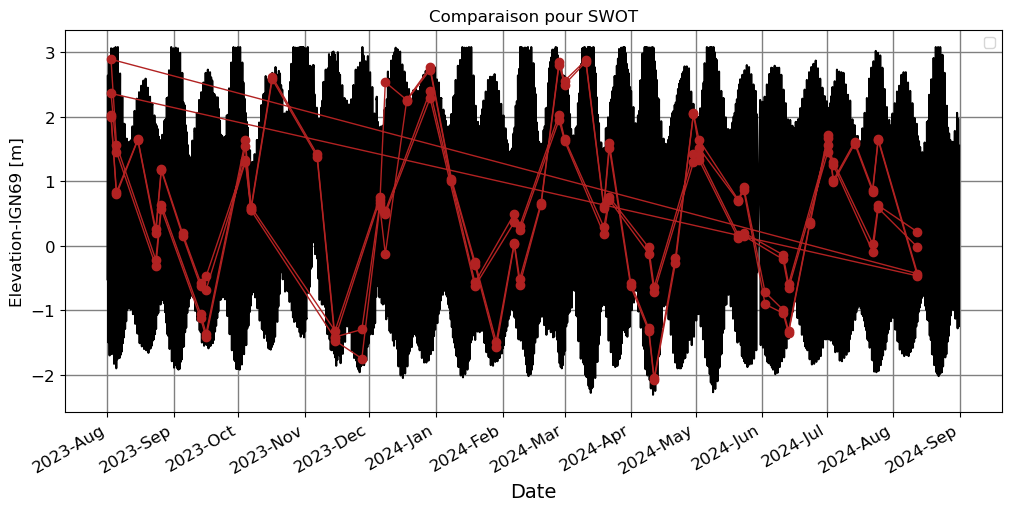

In [224]:
fig1, ax1 = plt.subplots(layout='constrained', figsize=(10,5))

ax1.plot(temps_insitu,elev_insitu, color='black')
ax1.plot(time_swot,list1_swot,color='firebrick',linewidth=1,marker='o')
ax1.plot(time_swot,list2_swot,color='firebrick',linewidth=1,marker='o')
time_swot=np.array(time_swot)
list1_swot=np.array(list1_swot)
list2_swot=np.array(list2_swot)
ax1.fill_between(time_swot,list2_swot,list1_swot,color='mistyrose',alpha=0)
#plt.fill(np.append(time_swot, time_swot), np.append(list1_swot, list2_swot), 'thistle')
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
ax1.set_ylabel(r"Elevation-IGN69 [m]",fontsize=12)
ax1.set_xlabel(r"Date",fontsize=14)
ax1.set_title(f'Comparaison pour SWOT')
ax1.tick_params(axis='both',labelsize=12)
ax1.grid(color='gray', linestyle='-', linewidth=1)
ax1.legend()
plt.tick_params(axis='both',labelsize=12)
fig1.autofmt_xdate(rotation=30)
plt.show()

/tmp/ipykernel_3383/2050369994.py:27: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig1.autofmt_xdate(rotation=30)


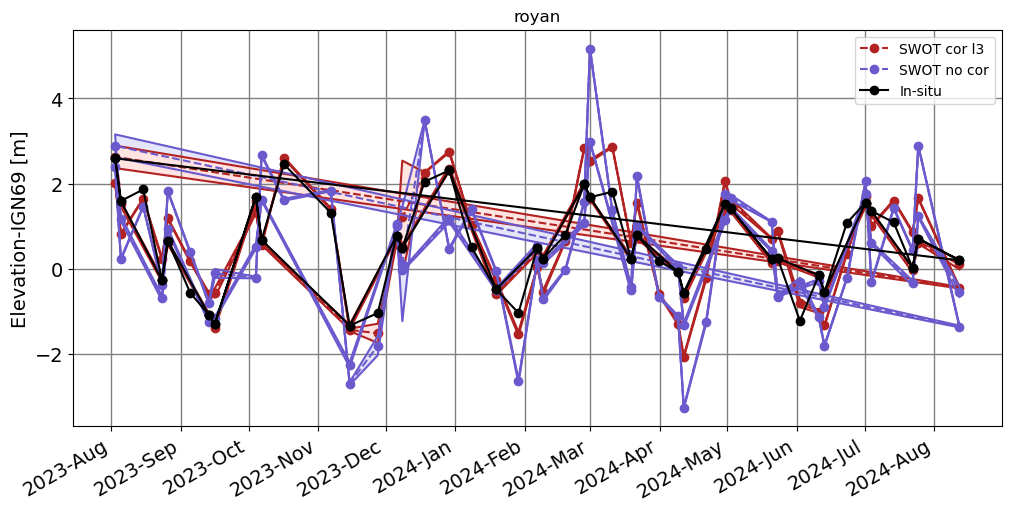

In [225]:
fig1, ax1 = plt.subplots(layout='constrained', figsize=(10,5))


ax1.plot(time_swot,list1_swot,color='firebrick')
ax1.plot(time_swot,list2_swot,color='firebrick')
ax1.plot(time_swot,moy,color='firebrick',linestyle='--',marker='o',label='SWOT cor l3')
ax1.plot(time_swot,list1_swot_nocor,color='slateblue')
ax1.plot(time_swot,list2_swot_nocor,color='slateblue')
ax1.plot(time_swot,moy_nocor,color='slateblue',linestyle='--',marker='o',label='SWOT no cor')
time_swot=np.array(time_swot)
list1_swot=np.array(list1_swot)
list2_swot=np.array(list2_swot)
ax1.fill_between(time_swot,list2_swot_nocor,list1_swot_nocor,color='lavender',alpha=1)
ax1.fill_between(time_swot,list2_swot,list1_swot,color='mistyrose',alpha=1)
ax1.plot(time_swot,insitu_time_swot, color='black',marker='o',label='In-situ')
#ax1.yaxis.set_major_locator(MultipleLocator(0.5))
#plt.fill(np.append(time_swot, time_swot), np.append(list1_swot, list2_swot), 'thistle')
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
ax1.set_ylabel(r"Elevation-IGN69 [m]",fontsize=14)
#ax1.set_xlabel(r"Date",fontsize=12)
ax1.set_title(f"{station}")
ax1.tick_params(axis='both',labelsize=14)
ax1.grid(color='gray', linestyle='-', linewidth=1)
ax1.legend()
plt.tick_params(axis='both',labelsize=14)
fig1.autofmt_xdate(rotation=30)
plt.savefig(f'./{station}_comp_bis.svg',format='svg',dpi=1200)
plt.show()

/tmp/ipykernel_32640/2972217206.py:27: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig1.autofmt_xdate(rotation=30)


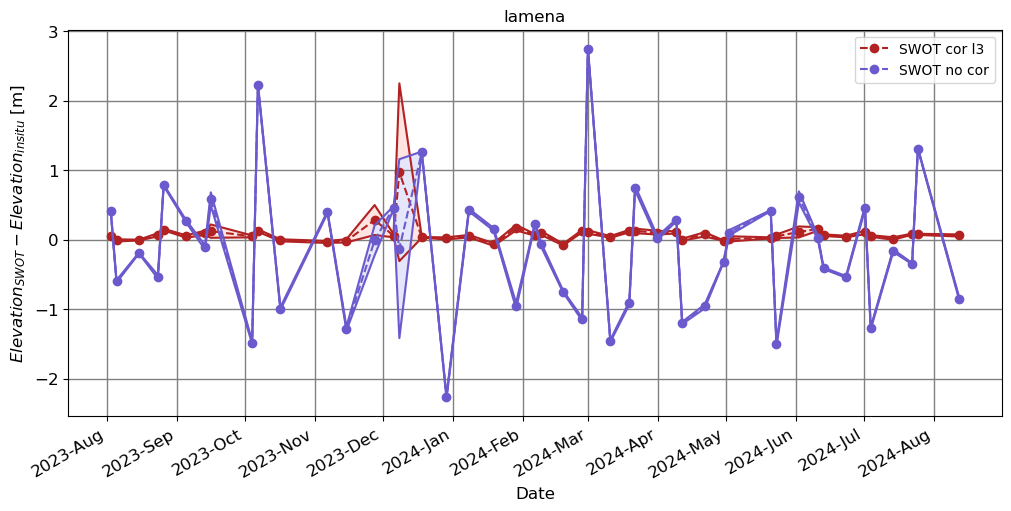

In [46]:
fig1, ax1 = plt.subplots(layout='constrained', figsize=(10,5))


ax1.plot(time_swot_diff,list1_diff_swot,color='firebrick')
ax1.plot(time_swot_diff,list2_diff_swot,color='firebrick')
ax1.plot(time_swot_diff,moy_diff_swot,color='firebrick',linestyle='--',marker='o',label='SWOT cor l3')
ax1.plot(time_swot_diff_nocor,list1_diff_swot_nocor,color='slateblue')
ax1.plot(time_swot_diff_nocor,list2_diff_swot_nocor,color='slateblue')
ax1.plot(time_swot_diff_nocor,moy_diff_swot_nocor,color='slateblue',linestyle='--',marker='o',label='SWOT no cor')
time_swot=np.array(time_swot)
list1_diff_swot=np.array(list1_diff_swot)
list2_diff_swot=np.array(list2_diff_swot)
ax1.fill_between(time_swot_diff,list2_diff_swot,list1_diff_swot,color='mistyrose',alpha=1)
ax1.fill_between(time_swot_diff_nocor,list2_diff_swot_nocor,list1_diff_swot_nocor,color='lavender',alpha=1)
#ax1.plot(time_swot,insitu_time_swot, color='black',marker='o',label='In-situ')
#plt.fill(np.append(time_swot, time_swot), np.append(list1_swot, list2_swot), 'thistle')
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
ax1.set_ylabel(r"$Elevation_{SWOT} - Elevation_{insitu}$ [m]",fontsize=12)
ax1.set_xlabel(r"Date",fontsize=12)
ax1.set_title(f"{station}")
ax1.tick_params(axis='both',labelsize=12)
ax1.grid(color='gray', linestyle='-', linewidth=1)
#ax1.set(ylim=(-0.5,0.5))
ax1.legend()
plt.tick_params(axis='both',labelsize=12)
fig1.autofmt_xdate(rotation=30)
plt.savefig(f'./{station}_diff_relatif.svg',format='svg',dpi=1200)
plt.show()

#### Calculation deviation from in-situ measurements

In [52]:
points1=[]
points2=[]
points3=[]
points4=[]
points5=[]

for i in range(len(pts)):
    points1.append(pts[i][0])
    points2.append(pts[i][1])
    points3.append(pts[i][2])
    points4.append(pts[i][3])
    points5.append(pts[i][4])
points1=np.abs(np.array(points1)-np.array(res))
points2=np.abs(np.array(points2)-np.array(res))
points3=np.abs(np.array(points3)-np.array(res))
points4=np.abs(np.array(points4)-np.array(res))
points5=np.abs(np.array(points5)-np.array(res))
np.mean(points1)

0.07049031673718571

/tmp/ipykernel_32640/3509258324.py:22: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig1.autofmt_xdate(rotation=30)


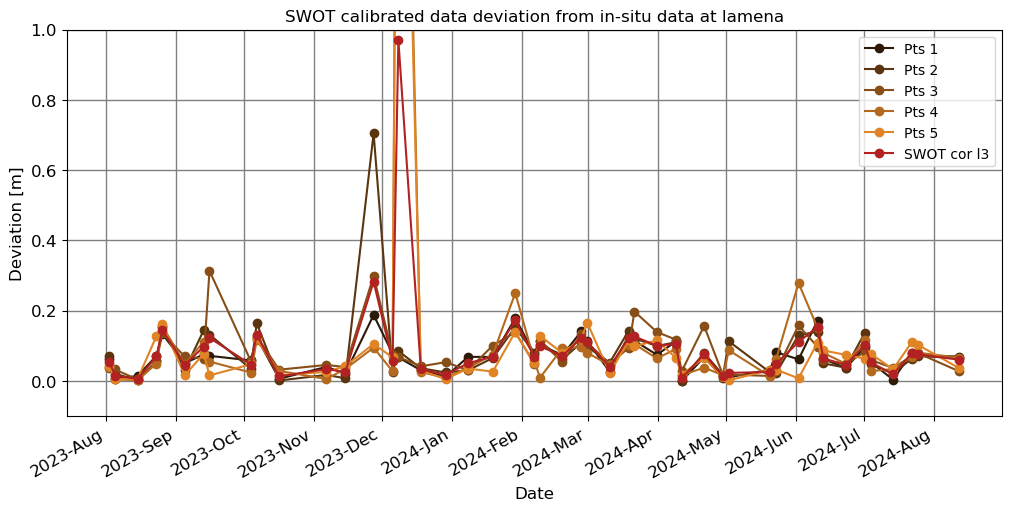

In [77]:
fig1, ax1 = plt.subplots(layout='constrained', figsize=(10,5))



ax1.plot(time_swot,points1,color='#2D1A08',linestyle='-',marker='o',label='Pts 1')
ax1.plot(time_swot,points2,color='#5A350F',linestyle='-',marker='o',label='Pts 2')
ax1.plot(time_swot,points3,color='#874F17',linestyle='-',marker='o',label='Pts 3')
ax1.plot(time_swot,points4,color='#B46A1E',linestyle='-',marker='o',label='Pts 4')
ax1.plot(time_swot,points5,color='#E18426',linestyle='-',marker='o',label='Pts 5')
ax1.plot(time_swot,moy_diff_swot,color='firebrick',linestyle='-',marker='o',label='SWOT cor l3')

ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
ax1.set_ylabel(r"Deviation [m]",fontsize=12)
ax1.set_xlabel(r"Date",fontsize=12)
ax1.set_title(f"SWOT calibrated data deviation from in-situ data at {station}")
ax1.tick_params(axis='both',labelsize=12)
ax1.grid(color='gray', linestyle='-', linewidth=1)
ax1.set(ylim=(-0.1,1))
ax1.legend()
plt.tick_params(axis='both',labelsize=12)
fig1.autofmt_xdate(rotation=30)
plt.savefig(f'./{station}_diff_pts_abs.svg',format='svg',dpi=1200)
plt.show()

In [61]:
np.mean(points1)

0.07049031673718571

In [62]:
np.sqrt(np.var(points1))

0.04630175088643615

In [63]:
np.mean(moy_diff_swot)

0.09358808900562665

In [64]:
np.sqrt(np.var(moy_diff_swot))

0.13940636472918083

In [65]:
def cumul(liste):
    nb=len(liste)
    cum=[1/nb]
    for i in range (1,nb):
        cum.append((i+1)/nb)
    return cum
    

In [66]:
cum1=cumul(points1)
cum2=cumul(points2)
cum3=cumul(points3)
cum4=cumul(points4)
cum5=cumul(points5)
cum=cumul(moy_diff_swot)
cum1

[0.02127659574468085,
 0.0425531914893617,
 0.06382978723404255,
 0.0851063829787234,
 0.10638297872340426,
 0.1276595744680851,
 0.14893617021276595,
 0.1702127659574468,
 0.19148936170212766,
 0.2127659574468085,
 0.23404255319148937,
 0.2553191489361702,
 0.2765957446808511,
 0.2978723404255319,
 0.3191489361702128,
 0.3404255319148936,
 0.3617021276595745,
 0.3829787234042553,
 0.40425531914893614,
 0.425531914893617,
 0.44680851063829785,
 0.46808510638297873,
 0.48936170212765956,
 0.5106382978723404,
 0.5319148936170213,
 0.5531914893617021,
 0.574468085106383,
 0.5957446808510638,
 0.6170212765957447,
 0.6382978723404256,
 0.6595744680851063,
 0.6808510638297872,
 0.7021276595744681,
 0.723404255319149,
 0.7446808510638298,
 0.7659574468085106,
 0.7872340425531915,
 0.8085106382978723,
 0.8297872340425532,
 0.851063829787234,
 0.8723404255319149,
 0.8936170212765957,
 0.9148936170212766,
 0.9361702127659575,
 0.9574468085106383,
 0.9787234042553191,
 1.0]

/tmp/ipykernel_32640/1451505158.py:20: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig1.autofmt_xdate(rotation=30)


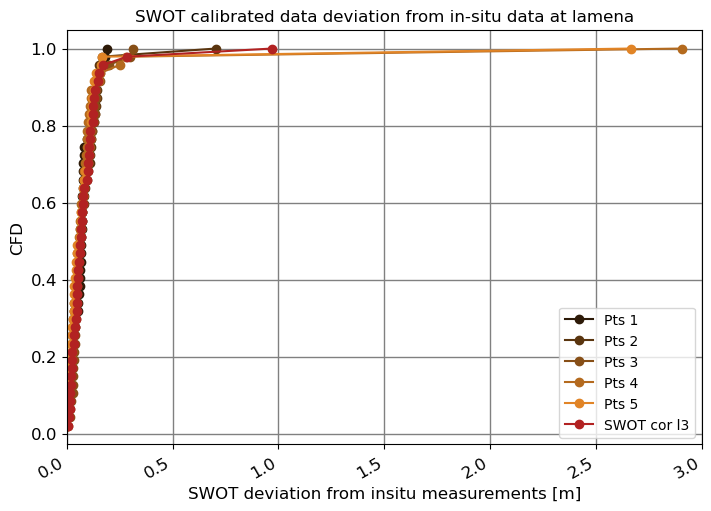

In [75]:
fig1, ax1 = plt.subplots(layout='constrained', figsize=(7,5))



ax1.plot(np.sort(points1),cum1,color='#2D1A08',linestyle='-',marker='o',label='Pts 1')
ax1.plot(np.sort(points2),cum2,color='#5A350F',linestyle='-',marker='o',label='Pts 2')
ax1.plot(np.sort(points3),cum3,color='#874F17',linestyle='-',marker='o',label='Pts 3')
ax1.plot(np.sort(points4),cum4,color='#B46A1E',linestyle='-',marker='o',label='Pts 4')
ax1.plot(np.sort(points5),cum5,color='#E18426',linestyle='-',marker='o',label='Pts 5')
ax1.plot(np.sort(moy_diff_swot),cum,color='firebrick',linestyle='-',marker='o',label='SWOT cor l3')

ax1.set_ylabel(r"CFD",fontsize=12)
ax1.set_xlabel(r"SWOT deviation from insitu measurements [m]",fontsize=12)
ax1.set_title(f"SWOT calibrated data deviation from in-situ data at {station}")
ax1.tick_params(axis='both',labelsize=12)
ax1.grid(color='gray', linestyle='-', linewidth=1)
ax1.set(xlim=(0,3))
ax1.legend()
plt.tick_params(axis='both',labelsize=12)
fig1.autofmt_xdate(rotation=30)
plt.savefig(f'./{station}_diff_pts_abs_cum.svg',format='svg',dpi=1200)
plt.show()

/tmp/ipykernel_32640/2334237284.py:20: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig1.autofmt_xdate(rotation=30)


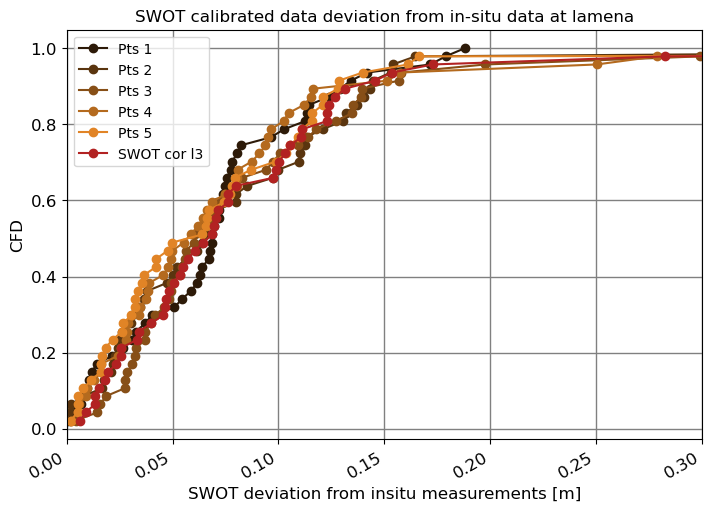

In [76]:
fig1, ax1 = plt.subplots(layout='constrained', figsize=(7,5))



ax1.plot(np.sort(points1),cum1,color='#2D1A08',linestyle='-',marker='o',label='Pts 1')
ax1.plot(np.sort(points2),cum2,color='#5A350F',linestyle='-',marker='o',label='Pts 2')
ax1.plot(np.sort(points3),cum3,color='#874F17',linestyle='-',marker='o',label='Pts 3')
ax1.plot(np.sort(points4),cum4,color='#B46A1E',linestyle='-',marker='o',label='Pts 4')
ax1.plot(np.sort(points5),cum5,color='#E18426',linestyle='-',marker='o',label='Pts 5')
ax1.plot(np.sort(moy_diff_swot),cum,color='firebrick',linestyle='-',marker='o',label='SWOT cor l3')

ax1.set_ylabel(r"CFD",fontsize=12)
ax1.set_xlabel(r"SWOT deviation from insitu measurements [m]",fontsize=12)
ax1.set_title(f"SWOT calibrated data deviation from in-situ data at {station}")
ax1.tick_params(axis='both',labelsize=12)
ax1.grid(color='gray', linestyle='-', linewidth=1)
ax1.set(xlim=(0,0.3))
ax1.legend()
plt.tick_params(axis='both',labelsize=12)
fig1.autofmt_xdate(rotation=30)
plt.savefig(f'./{station}_diff_pts_abs_cum_zoom.svg',format='svg',dpi=1200)
plt.show()

In [98]:
np.sort(points3)

array([0.01437972, 0.01584357, 0.01841058, 0.02744621, 0.02763381,
       0.02868177, 0.03288148, 0.03719239, 0.03977128, 0.04942988,
       0.05367897, 0.05569241, 0.05640408, 0.06015744, 0.06046582,
       0.06409246, 0.06826029, 0.07104606, 0.07461419, 0.07958836,
       0.0828566 , 0.09433818, 0.09732223, 0.10094865, 0.10909577,
       0.11404204, 0.11779261, 0.12713226, 0.13491508, 0.13529805,
       0.19779731, 0.3136153 ])

In [55]:
np.sqrt(np.var(moy_diff_swot))

0.16589897664967101

#### Plotting distances for each point from the closest to the farest

In [78]:
points1=[]
points2=[]
points3=[]
points4=[]
points5=[]

for i in range(len(dist)):
    points1.append(dist[i][0])
    points2.append(dist[i][1])
    points3.append(dist[i][2])
    points4.append(dist[i][3])
    points5.append(dist[i][4])
points1

[82.22548667818778,
 148.21405031790474,
 137.29225536826206,
 81.06294813117577,
 101.41766235070045,
 156.5798274228245,
 114.47318940078836,
 134.46251259401635,
 104.10737447416686,
 84.76400969086258,
 89.06768502157584,
 36.516433793430245,
 93.25249494662467,
 136.6542052256942,
 100.69461450310276,
 388.71452951163974,
 143.6083102397993,
 53.1716973267574,
 63.554376466352814,
 90.12771877597778,
 229.59932638503554,
 82.19192203108933,
 40.00574909057736,
 94.17589196103631,
 111.03749218497966,
 111.60361895611672,
 132.92415158193305,
 111.56369388831055,
 117.75184105426042,
 158.4044324769944,
 94.07984960975003,
 107.48852778115469,
 52.012360101519626,
 94.13317230065458,
 22.59172011092625,
 83.94965416829059,
 124.40609898833031,
 82.88421183189294,
 43.48894525323574,
 84.74354868464474,
 102.2047066198515,
 109.81607739227084,
 50.67184483582901,
 84.12209582122775,
 13.686499937997942,
 31.983404155696366,
 49.85858553221376]

/tmp/ipykernel_32640/2883029721.py:21: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig1.autofmt_xdate(rotation=30)


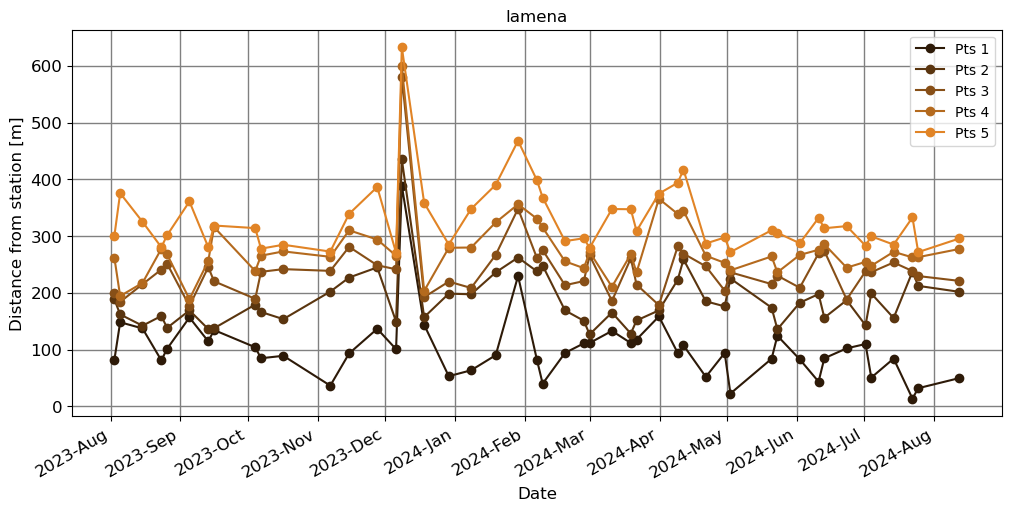

In [80]:
fig1, ax1 = plt.subplots(layout='constrained', figsize=(10,5))



ax1.plot(time_swot,points1,color='#2D1A08',linestyle='-',marker='o',label='Pts 1')
ax1.plot(time_swot,points2,color='#5A350F',linestyle='-',marker='o',label='Pts 2')
ax1.plot(time_swot,points3,color='#874F17',linestyle='-',marker='o',label='Pts 3')
ax1.plot(time_swot,points4,color='#B46A1E',linestyle='-',marker='o',label='Pts 4')
ax1.plot(time_swot,points5,color='#E18426',linestyle='-',marker='o',label='Pts 5')

ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
ax1.set_ylabel(r"Distance from station [m]",fontsize=12)
ax1.set_xlabel(r"Date",fontsize=12)
ax1.set_title(f"{station}")
ax1.tick_params(axis='both',labelsize=12)
ax1.grid(color='gray', linestyle='-', linewidth=1)
#ax1.set(ylim=(-0.5,0.5))
ax1.legend()
plt.tick_params(axis='both',labelsize=12)
fig1.autofmt_xdate(rotation=30)
plt.savefig(f'./{station}_distance_pts.svg',format='svg',dpi=1200)
plt.show()

/tmp/ipykernel_32207/3278885016.py:21: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig1.autofmt_xdate(rotation=30)


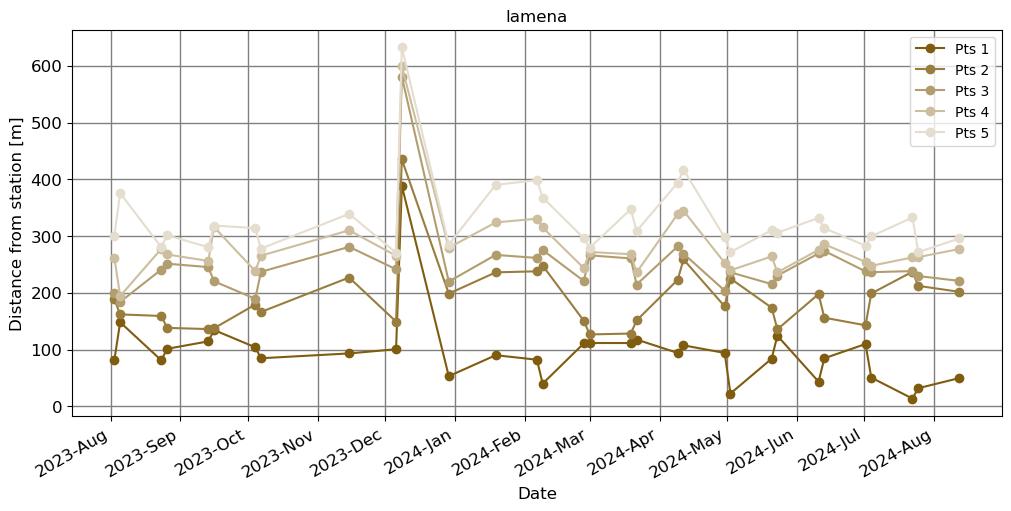

In [113]:
fig1, ax1 = plt.subplots(layout='constrained', figsize=(10,5))



ax1.plot(time_swot,points1,color='#7F5C0E',linestyle='-',marker='o',label='Pts 1')
ax1.plot(time_swot,points2,color='#997D3F',linestyle='-',marker='o',label='Pts 2')
ax1.plot(time_swot,points3,color='#B29D6E',linestyle='-',marker='o',label='Pts 3')
ax1.plot(time_swot,points4,color='#CCBE9F',linestyle='-',marker='o',label='Pts 4')
ax1.plot(time_swot,points5,color='#E5DECF',linestyle='-',marker='o',label='Pts 5')

ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
ax1.set_ylabel(r"Distance from station [m]",fontsize=12)
ax1.set_xlabel(r"Date",fontsize=12)
ax1.set_title(f"{station}")
ax1.tick_params(axis='both',labelsize=12)
ax1.grid(color='gray', linestyle='-', linewidth=1)
#ax1.set(ylim=(-0.5,0.5))
ax1.legend()
plt.tick_params(axis='both',labelsize=12)
fig1.autofmt_xdate(rotation=30)
plt.show()

In [ ]:
fig1, ax1 = plt.subplots(layout='constrained', figsize=(10,5))


ax1.plot(time_swot_diff,list1_diff_swot,color='firebrick')
ax1.plot(time_swot_diff,list2_diff_swot,color='firebrick')
ax1.plot(time_swot_diff,moy_diff_swot,color='firebrick',linestyle='--',marker='o',label='SWOT cor l3')
#ax1.plot(time_swot_diff_nocor,list1_diff_swot_nocor,color='slateblue')
#ax1.plot(time_swot_diff_nocor,list2_diff_swot_nocor,color='slateblue')
#ax1.plot(time_swot_diff_nocor,moy_diff_swot_nocor,color='slateblue',linestyle='--',marker='o',label='SWOT no cor')
time_swot=np.array(time_swot)
list1_diff_swot=np.array(list1_diff_swot)
list2_diff_swot=np.array(list2_diff_swot)
ax1.fill_between(time_swot_diff,list2_diff_swot,list1_diff_swot,color='mistyrose',alpha=1)
#ax1.fill_between(time_swot_diff_nocor,list2_diff_swot_nocor,list1_diff_swot_nocor,color='lavender',alpha=1)
#ax1.plot(time_swot,insitu_time_swot, color='black',marker='o',label='In-situ')
#plt.fill(np.append(time_swot, time_swot), np.append(list1_swot, list2_swot), 'thistle')
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
ax1.set_ylabel(r"|$Elevation_{SWOT} - Elevation_{insitu}$| [m]",fontsize=12)
ax1.set_xlabel(r"Date",fontsize=12)
ax1.set_title(f"{station}")
ax1.tick_params(axis='both',labelsize=12)
ax1.grid(color='gray', linestyle='-', linewidth=1)
ax1.set(ylim=(-0.5,0.5))
ax1.legend()
plt.tick_params(axis='both',labelsize=12)
fig1.autofmt_xdate(rotation=30)
plt.show()

##### 2.6 Utilisation valeurs directement interpolées ou choix du points où l'écart à SWOT est minimal

In [310]:
diff_swot=[]
diff_swot_nocor=[]
elev_swot=[]
elev_swot_nocor=[]
ind_cor=[]
ind_nocor=[]
for i in range (len(pts)):
    ind,elev,diff=choix_pts(pts[i],res[i])
    elev_swot.append(elev)
    diff_swot.append(diff)
    ind_cor.append(ind)
    ind,elev,diff=choix_pts(pts_nocor[i],res[i])
    elev_swot_nocor.append(elev)
    diff_swot_nocor.append(diff)
    ind_nocor.append(ind)
elev_swot,diff_swot

([0.011528225916073609,
  0.9738380344645279,
  2.487621366665003,
  2.781501602450291,
  1.6282371302286691,
  -0.42568818823612986,
  -1.3909571242037586,
  0.3483566637721225,
  0.8290717032578456,
  0.9404616709206337,
  -1.1164673574412731,
  -1.6098994183534714,
  -0.8906310521304803,
  2.5506248287270097,
  1.3081950526705555,
  -0.1536524075779795,
  -1.2597028775209367,
  -0.4465854503284703,
  1.6944865884815314,
  1.9706850715498447,
  1.5742307006558605,
  -1.2184565446333622],
 [0.1365282259160736,
  0.1338380344645279,
  0.14237863333499678,
  0.03849839754970885,
  0.09176286977133086,
  0.23931181176387017,
  0.19095712420375865,
  0.00164333622787749,
  0.13907170325784568,
  0.0054616709206336544,
  0.003532642558726984,
  0.030100581646528513,
  0.2543689478695197,
  0.0006248287270098629,
  0.13680494732944437,
  0.026347592422020505,
  0.19029712247906327,
  0.10158545032847033,
  0.1344865884815314,
  0.0693149284501553,
  0.08576929934413946,
  0.0615434553666378

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_32377/134379111.py:20: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig1.autofmt_xdate(rotation=30)


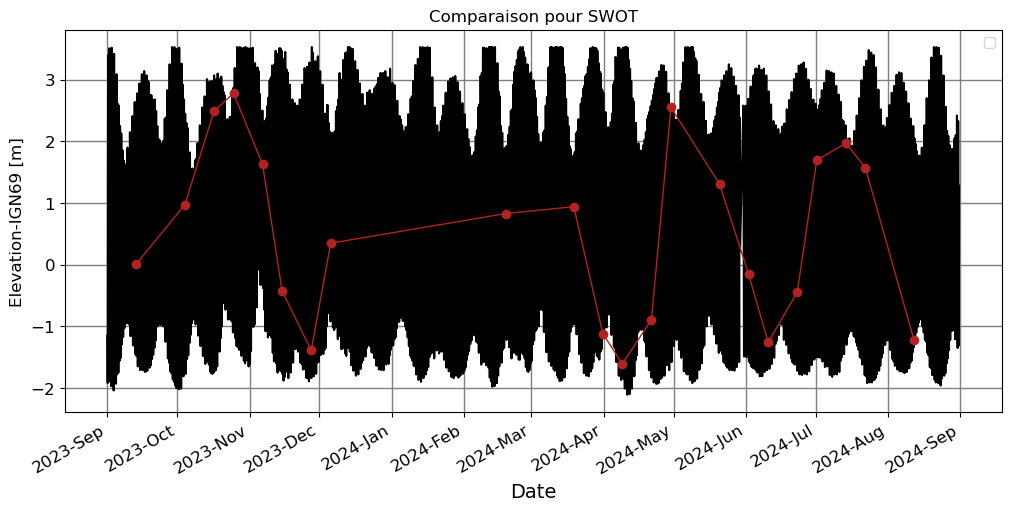

In [311]:
fig1, ax1 = plt.subplots(layout='constrained', figsize=(10,5))

ax1.plot(temps_insitu,elev_insitu, color='black')
ax1.plot(time_swot,elev_swot,color='firebrick',linewidth=1,marker='o')
#ax1.plot(time_swot,list2_swot,color='firebrick',linewidth=1,marker='o')
time_swot=np.array(time_swot)
#list1_swot=np.array(list1_swot)
#list2_swot=np.array(list2_swot)
#ax1.fill_between(time_swot,list2_swot,list1_swot,color='mistyrose',alpha=0)
#plt.fill(np.append(time_swot, time_swot), np.append(list1_swot, list2_swot), 'thistle')
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
ax1.set_ylabel(r"Elevation-IGN69 [m]",fontsize=12)
ax1.set_xlabel(r"Date",fontsize=14)
ax1.set_title(f'Comparaison pour SWOT')
ax1.tick_params(axis='both',labelsize=12)
ax1.grid(color='gray', linestyle='-', linewidth=1)
ax1.legend()
plt.tick_params(axis='both',labelsize=12)
fig1.autofmt_xdate(rotation=30)
plt.show()

/tmp/ipykernel_32377/3573487137.py:20: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig1.autofmt_xdate(rotation=30)


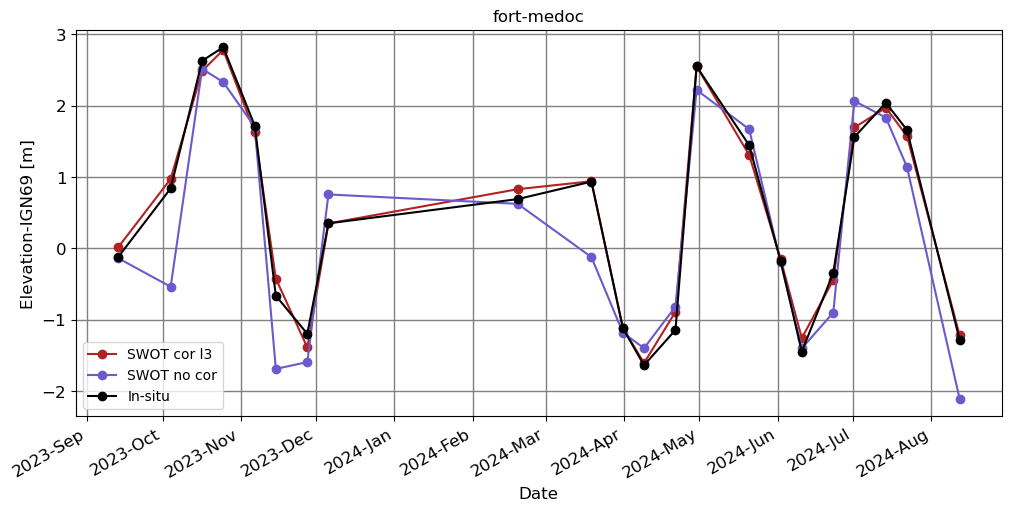

In [312]:
fig1, ax1 = plt.subplots(layout='constrained', figsize=(10,5))



ax1.plot(time_swot,elev_swot,color='firebrick',linestyle='-',marker='o',label='SWOT cor l3')
ax1.plot(time_swot,elev_swot_nocor,color='slateblue',linestyle='-',marker='o',label='SWOT no cor')
time_swot=np.array(time_swot)
ax1.plot(time_swot,insitu_time_swot, color='black',marker='o',label='In-situ')
#ax1.yaxis.set_major_locator(MultipleLocator(0.5))
#plt.fill(np.append(time_swot, time_swot), np.append(list1_swot, list2_swot), 'thistle')
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
ax1.set_ylabel(r"Elevation-IGN69 [m]",fontsize=12)
ax1.set_xlabel(r"Date",fontsize=12)
ax1.set_title(f"{station}")
ax1.tick_params(axis='both',labelsize=12)
ax1.grid(color='gray', linestyle='-', linewidth=1)
ax1.legend()
plt.tick_params(axis='both',labelsize=12)
fig1.autofmt_xdate(rotation=30)
plt.show()

/tmp/ipykernel_32377/3699727635.py:20: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig1.autofmt_xdate(rotation=30)


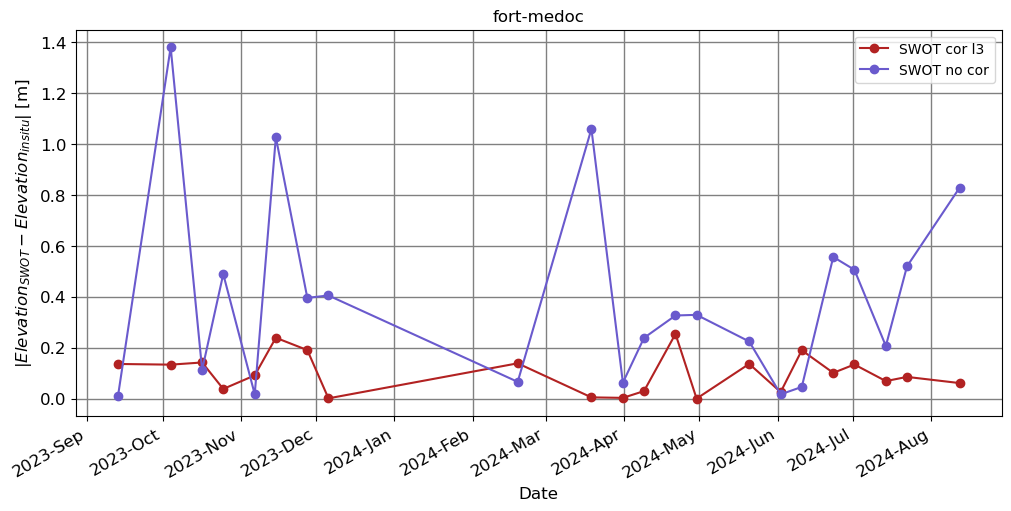

In [313]:
fig1, ax1 = plt.subplots(layout='constrained', figsize=(10,5))


ax1.plot(time_swot_diff,diff_swot,color='firebrick',linestyle='-',marker='o',label='SWOT cor l3')

ax1.plot(time_swot_diff_nocor,diff_swot_nocor,color='slateblue',linestyle='-',marker='o',label='SWOT no cor')

#ax1.plot(time_swot,insitu_time_swot, color='black',marker='o',label='In-situ')
#plt.fill(np.append(time_swot, time_swot), np.append(list1_swot, list2_swot), 'thistle')
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
ax1.set_ylabel(r"|$Elevation_{SWOT} - Elevation_{insitu}$| [m]",fontsize=12)
ax1.set_xlabel(r"Date",fontsize=12)
ax1.set_title(f"{station}")
ax1.tick_params(axis='both',labelsize=12)
ax1.grid(color='gray', linestyle='-', linewidth=1)
#ax1.set(ylim=(-0.2,1.5))
ax1.legend()
plt.tick_params(axis='both',labelsize=12)
fig1.autofmt_xdate(rotation=30)
plt.show()

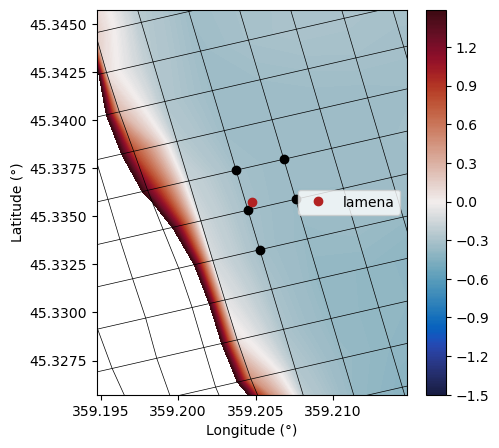

In [423]:
import cmocean
ds=xr.open_dataset(swot_files[0])
ds=interpolation_geoide_swot(ds,ds_geoide)
ds=calcul_ssha(ds)
longitude=ds.longitude.values
latitude=ds.latitude.values
taille=np.shape(latitude)
ind=0
extent=[lon-1,lon+1,lat-1,lat+1]
fig,ax = plt.subplots(figsize=(5,5))
im= ax.contourf(ds.longitude,ds.latitude,ds.ssha, np.arange(-1.5,1.5,0.01),cmap=cmocean.cm.balance)

longitudes=long[len(long)-1]
latitudes=lati[len(long)-1]
for i in range (len(longitudes)):
    ax.plot(longitudes[i],latitudes[i],'black',linewidth=0,marker='o')
#ax.plot(longitudes[ind_cor[-1]],latitudes[ind_cor[-1]],'black',linewidth=0,marker='o')
for k in range(taille[1]):
    ax.plot(longitude[:,k],latitude[:,k],'k',linewidth=0.5)
for j in range (taille[0]):
    ax.plot(longitude[j,:],latitude[j,:],'k',linewidth=0.5)
ax.plot(lon,lat,'firebrick',linewidth=0,marker='o',label=f'{station}')
ax.set(xlim=(lon-0.01,lon+0.01))
ax.set(ylim=(lat-0.01,lat+0.01))
ax.set_xlabel('Longitude (°)')
ax.set_ylabel('Latitude (°)')
ax.legend()
fig.colorbar(im)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


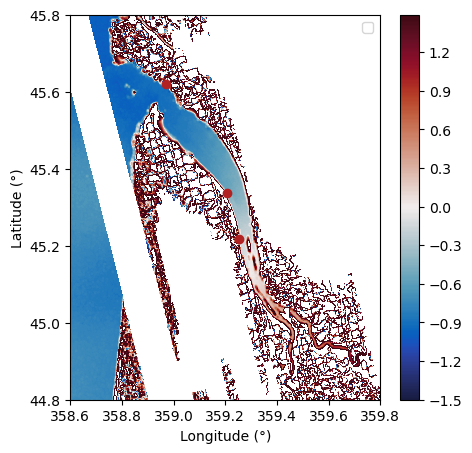

In [19]:
import cmocean
ds=xr.open_dataset(swot_files[0])
ds=interpolation_geoide_swot(ds,ds_geoide)
ds=calcul_ssha(ds)
longitude=ds.longitude.values
latitude=ds.latitude.values
taille=np.shape(latitude)
ind=0
extent=[lon-1,lon+1,lat-1,lat+1]
fig,ax = plt.subplots(figsize=(5,5))
im= ax.contourf(ds.longitude,ds.latitude,ds.ssha, np.arange(-1.5,1.5,0.01),cmap=cmocean.cm.balance)

#longitudes=long[len(long)-1]
#latitudes=lati[len(long)-1]
#for i in range (len(longitudes)):
    #ax.plot(longitudes[i],latitudes[i],'black',linewidth=0,marker='o')
#ax.plot(longitudes[ind_cor[-1]],latitudes[ind_cor[-1]],'black',linewidth=0,marker='o')
#for k in range(taille[1]):
    #ax.plot(longitude[:,k],latitude[:,k],'k',linewidth=0.5)
#for j in range (taille[0]):
    #ax.plot(longitude[j,:],latitude[j,:],'k',linewidth=0.5)
ax.plot(lon,lat,'firebrick',linewidth=0,marker='o')
ax.plot(359.253956,45.218042,'firebrick',linewidth=0,marker='o')
ax.plot(358.972189,45.620576,'firebrick',linewidth=0,marker='o')
ax.set(xlim=(358.6,359.8))
ax.set(ylim=(44.8,45.8))
ax.set_xlabel('Longitude (°)')
ax.set_ylabel('Latitude (°)')
ax.legend()
fig.colorbar(im)
plt.savefig('carte.svg',format='svg',dpi=1200)
plt.show()

In [265]:
time_swot

array(['2023-09-13T08:48:30.145452864', '2023-09-13T08:48:34.032804928',
       '2023-10-04T05:33:35.819794368', '2023-10-16T17:15:09.888916032',
       '2023-10-25T02:18:40.801889088', '2023-11-06T14:00:15.235289664',
       '2023-11-14T23:03:45.866174272', '2023-11-27T10:45:20.658128448',
       '2023-12-05T19:48:51.406950528', '2024-02-18T21:45:41.359679360',
       '2024-03-19T03:34:14.919232128', '2024-03-31T15:15:48.613887360',
       '2024-04-09T00:19:19.601575168', '2024-04-21T12:00:54.847962432',
       '2024-04-29T21:04:24.391596160', '2024-05-20T17:49:29.231045824',
       '2024-06-02T05:31:04.058336192', '2024-06-10T14:34:34.899366144',
       '2024-06-23T02:16:08.142512064', '2024-07-01T11:19:37.928296960',
       '2024-07-13T23:01:11.886867264', '2024-07-22T08:04:43.425849024',
       '2024-08-12T04:49:48.255895040'], dtype='datetime64[ns]')

In [429]:
time_swot

array(['2023-09-13T08:48:31.885505728', '2023-09-15T22:07:56.498665664',
       '2023-10-04T05:33:33.671993920', '2023-10-16T17:15:11.663502912',
       '2023-10-25T02:18:38.617057600', '2023-11-06T14:00:17.083847808',
       '2023-11-14T23:03:43.718611520', '2023-11-27T10:45:22.469262528',
       '2023-12-05T19:48:49.259284288', '2024-02-08T23:23:29.167653312',
       '2024-02-18T21:45:43.135095552', '2024-02-29T20:08:34.696261120',
       '2024-03-19T03:34:12.772568000', '2024-03-21T16:53:37.738192384',
       '2024-03-31T15:15:50.462454272', '2024-04-09T00:19:17.454776960',
       '2024-04-11T13:38:42.791081280', '2024-04-21T12:00:56.658673088',
       '2024-04-29T21:04:22.281591488', '2024-05-02T10:23:46.380560704',
       '2024-05-20T17:49:27.046460736', '2024-05-23T07:08:51.214807360',
       '2024-06-02T05:31:05.906432192', '2024-06-10T14:34:32.789214528',
       '2024-06-13T03:53:57.458062720', '2024-06-23T02:16:09.917099200',
       '2024-07-01T11:19:35.818275008', '2024-07-04

In [213]:
time_swot_diff

[numpy.datetime64('2023-09-13T08:48:34.032804928'),
 numpy.datetime64('2023-10-04T05:33:35.819794368'),
 numpy.datetime64('2023-10-16T17:15:09.851945536'),
 numpy.datetime64('2023-10-25T02:18:40.764858048'),
 numpy.datetime64('2023-11-06T14:00:15.235289664'),
 numpy.datetime64('2023-11-14T23:03:45.866174272'),
 numpy.datetime64('2023-11-27T10:45:20.658128448'),
 numpy.datetime64('2023-12-05T19:48:51.406950528'),
 numpy.datetime64('2024-02-18T21:45:41.322691456'),
 numpy.datetime64('2024-03-19T03:34:14.919232128'),
 numpy.datetime64('2024-03-31T15:15:48.613887360'),
 numpy.datetime64('2024-04-09T00:19:19.601575168'),
 numpy.datetime64('2024-04-21T12:00:54.811009088'),
 numpy.datetime64('2024-04-29T21:04:24.428609920'),
 numpy.datetime64('2024-05-20T17:49:29.194023424'),
 numpy.datetime64('2024-06-02T05:31:04.058336192'),
 numpy.datetime64('2024-06-10T14:34:34.899366144'),
 numpy.datetime64('2024-06-23T02:16:08.105541568'),
 numpy.datetime64('2024-07-01T11:19:37.965310720'),
 numpy.datet

In [317]:
np.where(np.array(moy_diff_swot)>2)

(array([10, 12, 17]),)

In [320]:
pts[17]

[-0.7219539913671085,
 15.768132597692144,
 24.791433177490255,
 23.44268220601399,
 -0.4465854503284703]

## 3- Comparaison données in-situ sur plusieurs stations

##### 3.1 Récupération des écarts à SWOT 

In [20]:
def conversion_time(times):
    for i in range (len(times)):
        times[i]=np.datetime64(times[i],'ns')
    return times

In [21]:
# Lamena

time_lam=['2023-09-13T08:48:31.885505728', '2023-09-15T22:07:56.498665664',
       '2023-10-04T05:33:33.671993920', '2023-10-16T17:15:11.663502912',
       '2023-10-25T02:18:38.617057600', '2023-11-06T14:00:17.083847808',
       '2023-11-14T23:03:43.718611520', '2023-11-27T10:45:22.469262528',
       '2023-12-05T19:48:49.259284288', '2024-02-08T23:23:29.167653312',
       '2024-02-18T21:45:43.135095552', '2024-02-29T20:08:34.696261120',
       '2024-03-19T03:34:12.772568000', '2024-03-21T16:53:37.738192384',
       '2024-03-31T15:15:50.462454272', '2024-04-09T00:19:17.454776960',
       '2024-04-11T13:38:42.791081280', '2024-04-21T12:00:56.658673088',
       '2024-04-29T21:04:22.281591488', '2024-05-02T10:23:46.380560704',
       '2024-05-20T17:49:27.046460736', '2024-05-23T07:08:51.214807360',
       '2024-06-02T05:31:05.906432192', '2024-06-10T14:34:32.789214528',
       '2024-06-13T03:53:57.458062720', '2024-06-23T02:16:09.917099200',
       '2024-07-01T11:19:35.818275008', '2024-07-04T00:38:59.840916800',
       '2024-07-13T23:01:13.698887040', '2024-07-22T08:04:41.278243008',
       '2024-07-24T21:24:05.743117504', '2024-08-12T04:49:46.108755392']
time_lam=conversion_time(time_lam)

elev_diff_lam=[0.20033179147887864,
 0.17883910760926622,
 0.15718761388853505,
 0.14941615707743708,
 0.046033949444414045,
 0.047618829615408254,
 0.25320458139008795,
 0.23708914778677195,
 0.08517088492026512,
 0.3769787817137366,
 0.11976904982479124,
 0.08124121873534262,
 0.0341947774828649,
 0.026359998905563387,
 0.22297696302819675,
 0.1080351130630543,
 0.2507512816921121,
 0.13366067052852107,
 0.004766437935066848,
 0.06468070736536524,
 0.09682971982131788,
 0.030764800974779287,
 0.1760952606959873,
 0.37035730229949315,
 0.0594491161560423,
 0.07411537635741915,
 0.22265389601666077,
 0.15372255228624918,
 0.05492058070822281,
 0.02287582631751719,
 0.06501244414739467,
 0.16736976211716276]

elev_diff_lam_nocor=[0.035601287202891484,
 0.6680175009995978,
 1.3644895711829668,
 1.1305810456235048,
 0.38831193692998506,
 0.3981071513436634,
 1.0157976740319226,
 0.1730147370481678,
 0.4722315360249641,
 0.20001787547590866,
 0.5859001286800636,
 2.7178833831346525,
 1.0011192687576769,
 0.6564933824232518,
 0.13275175102551273,
 0.3085442396556054,
 0.9745509159393294,
 0.8909005669705055,
 0.32773278771840836,
 0.054109236765241354,
 0.29596159380607695,
 1.515418996168939,
 0.6854880189209657,
 0.22966974731466877,
 0.43099555540484347,
 0.6601262168492968,
 0.578094765112204,
 1.3864014957763195,
 0.2359049784466365,
 0.44658336701420204,
 1.1714055497368585,
 0.7432670591372016]

In [22]:
# Pauillac

time_pau=['2023-09-13T08:48:30.145452864', '2023-09-13T08:48:34.032804928',
       '2023-10-04T05:33:35.819794368', '2023-10-16T17:15:09.888916032',
       '2023-10-25T02:18:40.801889088', '2023-11-06T14:00:15.235289664',
       '2023-11-14T23:03:45.866174272', '2023-11-27T10:45:20.658128448',
       '2023-12-05T19:48:51.406950528', '2024-02-18T21:45:41.359679360',
       '2024-03-19T03:34:14.919232128', '2024-03-31T15:15:48.613887360',
       '2024-04-09T00:19:19.601575168', '2024-04-21T12:00:54.847962432',
       '2024-04-29T21:04:24.391596160', '2024-05-20T17:49:29.231045824',
       '2024-06-02T05:31:04.058336192', '2024-06-10T14:34:34.899366144',
       '2024-06-23T02:16:08.142512064', '2024-07-01T11:19:37.928296960',
       '2024-07-13T23:01:11.886867264', '2024-07-22T08:04:43.425849024',
       '2024-08-12T04:49:48.255895040']

time_pau=conversion_time(time_pau)

elev_diff_pau=[0.26005791799705075,
 0.26344070010335247,
 0.1711733466548232,
 0.16381783097007965,
 0.079017584802641,
 0.10052698985575792,
 0.3897361505337895,
 0.21011571003864676,
 0.06512626471515906,
 0.1474776087204963,
 0.13954400279825374,
 0.17865639300105918,
 0.08710672068901464,
 0.08696497968745255,
 0.09785997488613918,
 0.08273800463293154,
 0.06889749157199906,
 0.35093968032749123,
 0.15350443332891736,
 0.19236867685225637,
 0.10888983558808173,
 0.15247834079952893,
 0.188143498640066]

elev_diff_pau_nocor=[ 0.4870979605774421,
 0.0918924767436767,
 1.391982643013786,
 0.9625565102464785,
 0.5281726730026906,
 0.39509384281423865,
 0.9076974743826799,
 0.2972219136015813,
 0.45015545968175946,
 0.49009842378944657,
 0.9569376693592632,
 0.10742872817670188,
 0.2926801026339629,
 0.7923565172076575,
 0.3133537856438365,
 0.3197681124238862,
 0.4739197201465539,
 0.2083655659901506,
 0.617938820163455,
 0.560794798432717,
 0.2375698202106184,
 0.3775563284145585,
 0.7465001048306467]

In [23]:
# Fort-medoc

time_for=['2023-09-13T08:48:35.846759936', '2023-10-04T05:33:37.634138176',
       '2023-10-16T17:15:09.371328192', '2023-10-25T02:18:42.579227840',
       '2023-11-06T14:00:14.754672192', '2023-11-14T23:03:47.680271808',
       '2023-11-27T10:45:19.992813888', '2023-12-05T19:48:53.221048128',
       '2024-02-18T21:45:40.693898240', '2024-03-19T03:34:16.769488256',
       '2024-03-31T15:15:46.987182528', '2024-04-09T00:19:21.415046336',
       '2024-04-21T12:00:54.182803328', '2024-04-29T21:04:26.242284160',
       '2024-05-20T17:49:31.008121024', '2024-06-02T05:31:02.542897280',
       '2024-06-10T14:34:36.750054144', '2024-06-23T02:16:06.441866176',
       '2024-07-01T11:19:39.778985152', '2024-07-13T23:01:10.296761408',
       '2024-07-22T08:04:45.239946688', '2024-08-12T04:49:50.069569344']

time_for=conversion_time(time_for)

elev_diff_for=[0.15899906425572177,
 0.14989008502867082,
 0.31860102073742735,
 0.06526718892890496,
 0.19160083086465166,
 0.27146556256232346,
 0.2841714281927127,
 0.015931394633320536,
 0.27968082106122455,
 0.035845562321482255,
 0.15630724457079412,
 0.0595942204426221,
 0.5078556604754085,
 0.03250035764908217,
 0.15715379697408108,
 0.23945383831654896,
 0.2188260856635858,
 0.2918330614453398,
 0.16696271119959177,
 0.29389343351686564,
 0.09930192516728904,
 0.08451453001526259]

elev_diff_for_nocor=[ 0.06827875457033296,
 1.4254703682429708,
 0.5819942114649734,
 0.5173713577976136,
 0.11949870736363363,
 1.0489629109653653,
 0.4901088642907619,
 0.4198030454138241,
 0.2374968078841498,
 1.1018321071171893,
 0.11942012733276725,
 0.26701750450448036,
 0.42178362367138933,
 0.3640767141133943,
 0.24704822401513188,
 0.23979363302028125,
 0.07521824243515547,
 0.6917078146225065,
 0.5386714169797647,
 0.43120938302291695,
 0.5338689545465325,
 0.85913453462164]

In [24]:
# Royan

time_roy=[ '2023-09-13T08:48:26.480235200', '2023-09-15T22:08:00.454515904',
       '2023-10-04T05:33:28.265461952', '2023-10-25T02:18:33.210525696',
       '2023-11-14T23:03:38.312079488', '2023-12-05T19:48:43.852752192',
       '2024-02-08T23:23:33.088364480', '2024-02-29T20:08:38.690947968',
       '2024-03-19T03:34:07.368558848', '2024-03-21T16:53:41.731946176',
       '2024-04-09T00:19:12.050767744', '2024-04-11T13:38:46.746931264',
       '2024-04-29T21:04:16.839298496', '2024-05-02T10:23:50.371514944',
       '2024-05-20T17:49:21.639928640', '2024-05-23T07:08:55.206694656',
       '2024-06-10T14:34:27.383943744', '2024-06-13T03:54:01.451816512',
       '2024-07-01T11:19:30.413004480', '2024-07-04T00:39:03.797691392',
       '2024-07-22T08:04:35.871711040', '2024-07-24T21:24:09.736871168',
       '2024-08-12T04:49:40.666462528']

time_roy=conversion_time(time_roy)

elev_diff_roy=[0.11994082963233228,
 0.03128101114310941,
 0.03749505126864032,
 0.19230979159736578,
 0.20374080503449263,
 0.03775530400352678,
 0.3867465531293662,
 0.06532758128253593,
 0.077783147084908,
 0.1618346855957306,
 0.04553594735477078,
 0.13608005905639317,
 0.17146979014403504,
 0.10829083876564193,
 0.19076058387138134,
 0.07463726769302192,
 0.19362893521415853,
 0.08992861693587458,
 0.07962967682092296,
 0.22525077000868685,
 0.10692686398589195,
 0.24507988029722017,
 0.10631265773498198]

elev_diff_roy_nocor=[0.057645001301638625,
 0.22139298343526395,
 1.058205820945562,
 0.4905015359366523,
 0.6884202768099135,
 0.27353067037831125,
 0.23849109889680045,
 1.2625304347926865,
 0.8197353287794178,
 0.144906572205299,
 0.1410598978025832,
 0.5324213665656526,
 0.4000238150655422,
 0.04935116511761117,
 0.08337536006893845,
 0.8897074568060522,
 0.07158293614477554,
 0.3637137001057143,
 0.31041532635836866,
 0.8668502492977197,
 0.4214507237697167,
 0.37933316936633626,
 0.6292719359875977]

In [25]:
# Verdon-sur-mer

time_ver=['2023-09-13T08:48:27.146638336', '2023-09-15T22:07:59.530251840',
       '2023-10-04T05:33:28.932020672', '2023-10-25T02:18:33.877084352',
       '2023-11-14T23:03:38.978638272', '2023-12-05T19:48:44.519311040',
       '2024-02-08T23:23:32.200656256', '2024-02-29T20:08:37.766251776',
       '2024-03-19T03:34:08.071820288', '2024-03-21T16:53:40.770486848',
       '2024-04-09T00:19:12.717015424', '2024-04-11T13:38:45.822667200',
       '2024-04-29T21:04:17.542724032', '2024-05-02T10:23:49.410729664',
       '2024-05-20T17:49:22.306487360', '2024-05-23T07:08:54.282646592',
       '2024-06-10T14:34:28.050347072', '2024-06-13T03:54:00.490357184',
       '2024-07-01T11:19:31.079407680', '2024-07-04T00:39:02.873211328',
       '2024-07-22T08:04:36.538269888', '2024-07-24T21:24:08.775411904',
       '2024-08-12T04:49:41.369888192']

time_ver=conversion_time(time_ver)

elev_diff_ver=[0.07119668061766642,
 0.08270064901667984,
 0.010294414274854453,
 0.2235418939995495,
 0.14615115291565514,
 0.057806577646196504,
 0.2752873159050796,
 0.06494651824864844,
 0.0768261226339131,
 0.10058910945535413,
 0.011542820091172247,
 0.25653305181787084,
 0.07236426635318274,
 0.07852620314384225,
 0.1636938987938024,
 0.05802890319559335,
 0.21787836026461774,
 0.041826940391133015,
 0.12249937825721681,
 0.15206516358660513,
 0.10223677552108756,
 0.1893667857583504,
 0.07860857906597572]

elev_diff_ver_nocor=[ 0.08711097140076986,
 0.1496242941590657,
 0.898303862529263,
 0.47284081162467206,
 0.587984501912862,
 0.14647759018926224,
 0.12907960512193062,
 1.209248721827994,
 0.7093559184468066,
 0.1913391929259158,
 0.11083423652050135,
 0.3919004955288649,
 0.2582298232678724,
 0.04405861738377447,
 0.061815434920147794,
 0.8409410381920874,
 0.10198617607478908,
 0.3056062542788795,
 0.3046024244802765,
 0.7709458428658797,
 0.370506427131928,
 0.40954825523789234,
 0.4521149728209738]

/tmp/ipykernel_3491/1906206805.py:30: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig1.autofmt_xdate(rotation=30)


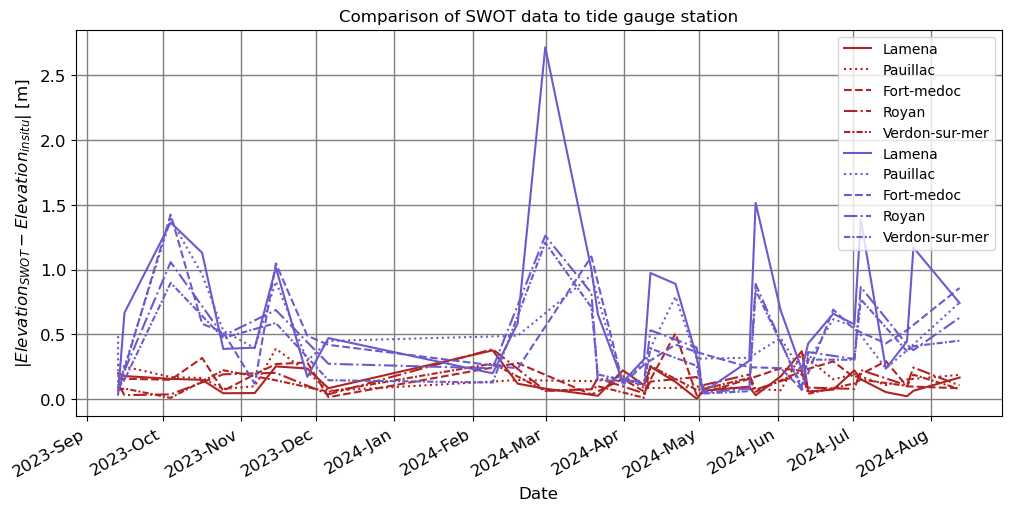

In [50]:
fig1, ax1 = plt.subplots(layout='constrained', figsize=(10,5))



ax1.plot(time_lam,elev_diff_lam,color='firebrick',linestyle='-',label='Lamena')
ax1.plot(time_pau,elev_diff_pau,color='firebrick',linestyle='dotted',label='Pauillac')
ax1.plot(time_for,elev_diff_for,color='firebrick',linestyle='dashed',label='Fort-medoc')
ax1.plot(time_roy,elev_diff_roy,color='firebrick',linestyle='dashdot',label='Royan')
ax1.plot(time_ver,elev_diff_ver,color='firebrick',linestyle=(0, (3, 1, 1, 1)),label='Verdon-sur-mer')

ax1.plot(time_lam,elev_diff_lam_nocor,color='slateblue',linestyle='-',label='Lamena')
ax1.plot(time_pau,elev_diff_pau_nocor,color='slateblue',linestyle='dotted',label='Pauillac')
ax1.plot(time_for,elev_diff_for_nocor,color='slateblue',linestyle='dashed',label='Fort-medoc')
ax1.plot(time_roy,elev_diff_roy_nocor,color='slateblue',linestyle='dashdot',label='Royan')
ax1.plot(time_ver,elev_diff_ver_nocor,color='slateblue',linestyle=(0, (3, 1, 1, 1)),label='Verdon-sur-mer')
#ax1.plot(time_pau,elev,color='slateblue',linestyle='-',marker='o',label='SWOT no cor')
#time_swot=np.array(time_swot)
#ax1.plot(time_swot,insitu_time_swot, color='black',marker='o',label='In-situ')
#ax1.yaxis.set_major_locator(MultipleLocator(0.5))
#plt.fill(np.append(time_swot, time_swot), np.append(list1_swot, list2_swot), 'thistle')
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
ax1.set_ylabel(r"|$Elevation_{SWOT} - Elevation_{insitu}$| [m]",fontsize=12)
ax1.set_xlabel(r"Date",fontsize=12)
ax1.set_title(f"Comparison of SWOT data to tide gauge station")
ax1.tick_params(axis='both',labelsize=12)
ax1.grid(color='gray', linestyle='-', linewidth=1)
ax1.legend()
plt.tick_params(axis='both',labelsize=12)
fig1.autofmt_xdate(rotation=30)
plt.show()

/tmp/ipykernel_32596/3613500490.py:30: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig1.autofmt_xdate(rotation=30)


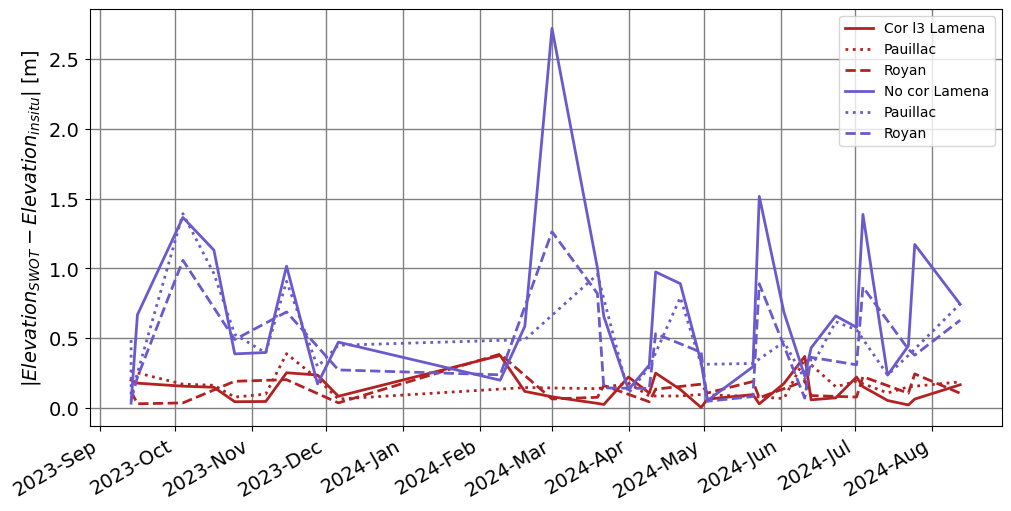

In [27]:
fig1, ax1 = plt.subplots(layout='constrained', figsize=(10,5))



ax1.plot(time_lam,elev_diff_lam,color='firebrick',linestyle='-',linewidth=2,label='Cor l3 Lamena')
ax1.plot(time_pau,elev_diff_pau,color='firebrick',linestyle='dotted',linewidth=2,label='Pauillac')
#ax1.plot(time_for,elev_diff_for,color='firebrick',linestyle='dashed',label='Fort-medoc')
ax1.plot(time_roy,elev_diff_roy,color='firebrick',linestyle='dashed',linewidth=2,label='Royan')
#ax1.plot(time_ver,elev_diff_ver,color='firebrick',linestyle=(0, (3, 1, 1, 1)),label='Verdon-sur-mer')

ax1.plot(time_lam,elev_diff_lam_nocor,color='slateblue',linestyle='-',linewidth=2,label='No cor Lamena')
ax1.plot(time_pau,elev_diff_pau_nocor,color='slateblue',linestyle='dotted',linewidth=2,label='Pauillac')
#ax1.plot(time_for,elev_diff_for_nocor,color='slateblue',linestyle='dashed',label='Fort-medoc')
ax1.plot(time_roy,elev_diff_roy_nocor,color='slateblue',linestyle='dashed',linewidth=2,label='Royan')
#ax1.plot(time_ver,elev_diff_ver_nocor,color='slateblue',linestyle=(0, (3, 1, 1, 1)),label='Verdon-sur-mer')
#ax1.plot(time_pau,elev,color='slateblue',linestyle='-',marker='o',label='SWOT no cor')
#time_swot=np.array(time_swot)
#ax1.plot(time_swot,insitu_time_swot, color='black',marker='o',label='In-situ')
#ax1.yaxis.set_major_locator(MultipleLocator(0.5))
#plt.fill(np.append(time_swot, time_swot), np.append(list1_swot, list2_swot), 'thistle')
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
ax1.set_ylabel(r"|$Elevation_{SWOT} - Elevation_{insitu}$| [m]",fontsize=14)
#ax1.set_xlabel(r"Date",fontsize=12)
#ax1.set_title(f"Comparison of SWOT data to tide gauge station")
ax1.tick_params(axis='both',labelsize=14)
ax1.grid(color='gray', linestyle='-', linewidth=1)
ax1.legend()
plt.tick_params(axis='both',labelsize=14)
fig1.autofmt_xdate(rotation=30)
plt.savefig('image_test.svg',format='svg',dpi=1200)
plt.show()

/tmp/ipykernel_3657/1049018249.py:30: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig1.autofmt_xdate(rotation=30)


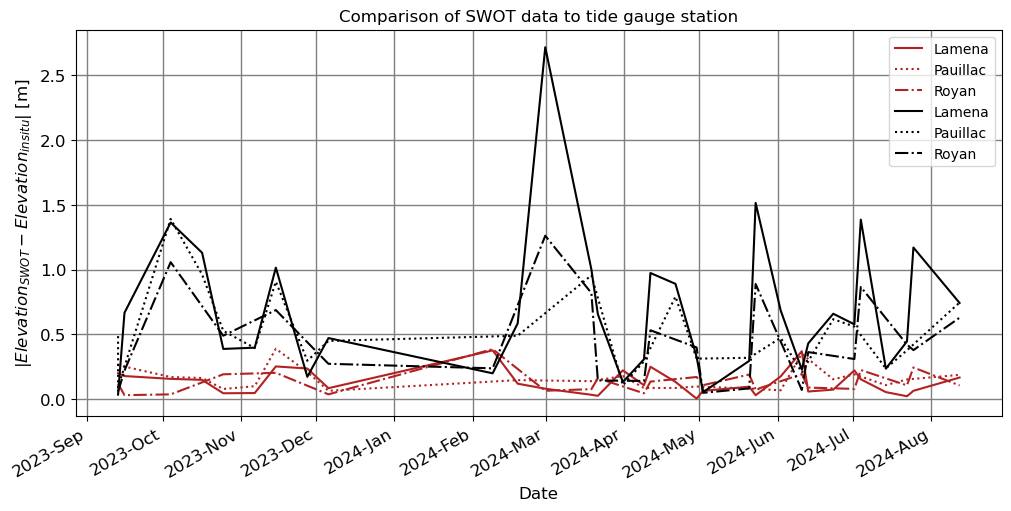

In [24]:
fig1, ax1 = plt.subplots(layout='constrained', figsize=(10,5))



ax1.plot(time_lam,elev_diff_lam,color='firebrick',linestyle='-',label='Lamena')
ax1.plot(time_pau,elev_diff_pau,color='firebrick',linestyle='dotted',label='Pauillac')
#ax1.plot(time_for,elev_diff_for,color='firebrick',linestyle='dashed',label='Fort-medoc')
ax1.plot(time_roy,elev_diff_roy,color='firebrick',linestyle='dashdot',label='Royan')
#ax1.plot(time_ver,elev_diff_ver,color='firebrick',linestyle=(0, (3, 1, 1, 1)),label='Verdon-sur-mer')

ax1.plot(time_lam,elev_diff_lam_nocor,color='k',linestyle='-',label='Lamena')
ax1.plot(time_pau,elev_diff_pau_nocor,color='k',linestyle='dotted',label='Pauillac')
#ax1.plot(time_for,elev_diff_for_nocor,color='slateblue',linestyle='dashed',label='Fort-medoc')
ax1.plot(time_roy,elev_diff_roy_nocor,color='k',linestyle='dashdot',label='Royan')
#ax1.plot(time_ver,elev_diff_ver_nocor,color='slateblue',linestyle=(0, (3, 1, 1, 1)),label='Verdon-sur-mer')
#ax1.plot(time_pau,elev,color='slateblue',linestyle='-',marker='o',label='SWOT no cor')
#time_swot=np.array(time_swot)
#ax1.plot(time_swot,insitu_time_swot, color='black',marker='o',label='In-situ')
#ax1.yaxis.set_major_locator(MultipleLocator(0.5))
#plt.fill(np.append(time_swot, time_swot), np.append(list1_swot, list2_swot), 'thistle')
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
ax1.set_ylabel(r"|$Elevation_{SWOT} - Elevation_{insitu}$| [m]",fontsize=12)
ax1.set_xlabel(r"Date",fontsize=12)
ax1.set_title(f"Comparison of SWOT data to tide gauge station")
ax1.tick_params(axis='both',labelsize=12)
ax1.grid(color='gray', linestyle='-', linewidth=1)
ax1.legend()
plt.tick_params(axis='both',labelsize=12)
fig1.autofmt_xdate(rotation=30)
plt.show()

/tmp/ipykernel_3491/2195424688.py:26: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig1.autofmt_xdate(rotation=30)


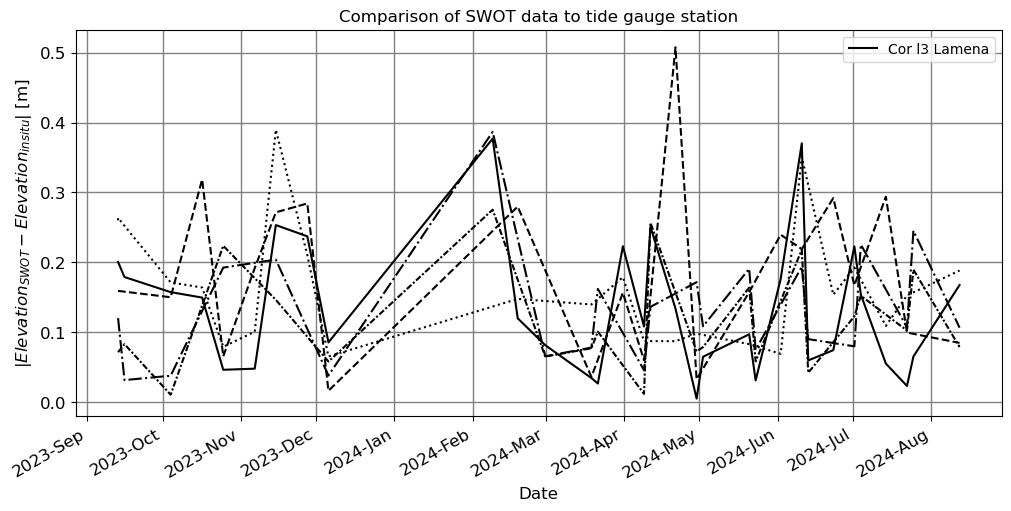

In [51]:
fig1, ax1 = plt.subplots(layout='constrained', figsize=(10,5))



ax1.plot(time_lam,elev_diff_lam,color='k',linestyle='-',label='Cor l3 Lamena')
ax1.plot(time_pau,elev_diff_pau,color='k',linestyle='dotted')
ax1.plot(time_for,elev_diff_for,color='k',linestyle='dashed')
ax1.plot(time_roy,elev_diff_roy,color='k',linestyle='dashdot')
ax1.plot(time_ver,elev_diff_ver,color='k',linestyle=(0, (3, 1, 1, 1)))


#ax1.plot(time_pau,elev,color='slateblue',linestyle='-',marker='o',label='SWOT no cor')
#time_swot=np.array(time_swot)
#ax1.plot(time_swot,insitu_time_swot, color='black',marker='o',label='In-situ')
#ax1.yaxis.set_major_locator(MultipleLocator(0.5))
#plt.fill(np.append(time_swot, time_swot), np.append(list1_swot, list2_swot), 'thistle')
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
ax1.set_ylabel(r"|$Elevation_{SWOT} - Elevation_{insitu}$| [m]",fontsize=12)
ax1.set_xlabel(r"Date",fontsize=12)
ax1.set_title(f"Comparison of SWOT data to tide gauge station")
ax1.tick_params(axis='both',labelsize=12)
ax1.grid(color='gray', linestyle='-', linewidth=1)
ax1.legend()
plt.tick_params(axis='both',labelsize=12)
fig1.autofmt_xdate(rotation=30)
plt.show()

/tmp/ipykernel_3657/4199843563.py:26: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig1.autofmt_xdate(rotation=30)


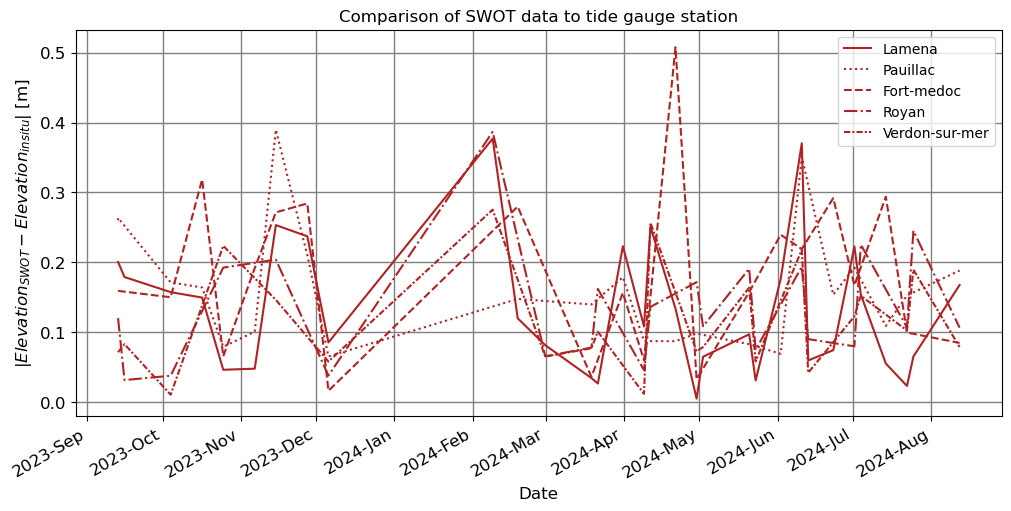

In [27]:
fig1, ax1 = plt.subplots(layout='constrained', figsize=(10,5))



ax1.plot(time_lam,elev_diff_lam,color='firebrick',linestyle='-',label='Lamena')
ax1.plot(time_pau,elev_diff_pau,color='firebrick',linestyle='dotted',label='Pauillac')
ax1.plot(time_for,elev_diff_for,color='firebrick',linestyle='dashed',label='Fort-medoc')
ax1.plot(time_roy,elev_diff_roy,color='firebrick',linestyle='dashdot',label='Royan')
ax1.plot(time_ver,elev_diff_ver,color='firebrick',linestyle=(0, (3, 1, 1, 1)),label='Verdon-sur-mer')


#ax1.plot(time_pau,elev,color='slateblue',linestyle='-',marker='o',label='SWOT no cor')
#time_swot=np.array(time_swot)
#ax1.plot(time_swot,insitu_time_swot, color='black',marker='o',label='In-situ')
#ax1.yaxis.set_major_locator(MultipleLocator(0.5))
#plt.fill(np.append(time_swot, time_swot), np.append(list1_swot, list2_swot), 'thistle')
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
ax1.set_ylabel(r"|$Elevation_{SWOT} - Elevation_{insitu}$| [m]",fontsize=12)
ax1.set_xlabel(r"Date",fontsize=12)
ax1.set_title(f"Comparison of SWOT data to tide gauge station")
ax1.tick_params(axis='both',labelsize=12)
ax1.grid(color='gray', linestyle='-', linewidth=1)
ax1.legend()
plt.tick_params(axis='both',labelsize=12)
fig1.autofmt_xdate(rotation=30)
plt.show()